## Load required packages

In [1]:
import h5py
import numpy as np
import scanpy as sc
import torch
import random

from scAClc import run_scaclc


## Set seed

In [2]:
seed = 666
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)



## Read data

In [3]:
# This data could be downloaded from https://drive.google.com/drive/folders/1c33An3HNdJQhazoy_ky9E-lCc3a4y7fl
file_path = r'C:\Users\ROG\Downloads\human_pbmc.h5'
data_mat = h5py.File(file_path, 'r')
x, y = np.array(data_mat['X']), np.array(data_mat['Y'])
data_mat.close()

adata = sc.AnnData(x)
adata.obs['celltype'] = y

In [3]:
import h5py
import numpy as np
import scanpy as sc
from scipy.sparse import csr_matrix

def read_sparse_matrix(file_path):
    """
    从 HDF5 文件中读取稀疏矩阵数据并转换为密集矩阵
    """
    data_mat = h5py.File(file_path, 'r')
    data = np.array(data_mat['exprs']['data'])
    indices = np.array(data_mat['exprs']['indices'])
    indptr = np.array(data_mat['exprs']['indptr'])
    shape = tuple(np.array(data_mat['exprs']['shape']))
    sparse_matrix = csr_matrix((data, indices, indptr), shape=shape)
    data_mat.close()
    return sparse_matrix.toarray()

def read_labels(file_path):
    """
    从 HDF5 文件中读取标签信息
    """
    data_mat = h5py.File(file_path, 'r')
    obs = data_mat['obs']
    cell_name = np.array(obs['cell_type1'])
    cell_type, y = np.unique(cell_name, return_inverse=True)
    data_mat.close()
    return y

file_path = r'C:\Users\ROG\数据包\20 datasets\Muraro\data.h5'
#file_path = r'C:\Users\ROG\Downloads\Mouse_k.h5'
# 读取稀疏矩阵数据
x = read_sparse_matrix(file_path)

# 读取标签信息
y = read_labels(file_path)

# 显式指定数据类型
adata = sc.AnnData(x, dtype=x.dtype)

# 转换 adata.X 的数据类型为 float64
adata.X = adata.X.astype(np.float64)

# 确保标签长度和数据行数一致
if len(y) != adata.n_obs:
    print(f"标签长度 {len(y)} 与数据行数 {adata.n_obs} 不一致，请检查数据。")
else:
    adata.obs['celltype'] = y

print("成功创建 AnnData 对象，adata 基本信息：")
print(adata)

成功创建 AnnData 对象，adata 基本信息：
AnnData object with n_obs × n_vars = 2122 × 19046
    obs: 'celltype'


## Perform data pre-processing

In [4]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)
adata.raw = adata.copy()

sc.pp.normalize_per_cell(adata)
adata.obs['scale_factor'] = adata.obs.n_counts / adata.obs.n_counts.mean()

sc.pp.log1p(adata)
#sc.pp.scale(adata)

In [5]:
adata

AnnData object with n_obs × n_vars = 4271 × 16486
    obs: 'celltype', 'n_genes', 'n_counts', 'scale_factor'
    var: 'n_cells'
    uns: 'log1p'

## Run scAClc

In default mode, function `run_scaclc` would return an AnnData object with embedding and clustering result stored in `adata.obsm['scaclc_emb']` and `adata.obs['scaclc_cluster']`

In [6]:
# adata = run_scaclc(adata)

If return_all is True, function `run_scaclc` would print and return all temporate results:

- K: Final number of clusters.
- pred_all: All temporary clustering results.
- emb_all: All temporary embedding.


In [7]:
# adata, K, pred_all, emb_all, run_time = run_scaclc(adata, return_all=True)

If the key of grount truth cell type (i.e. `cl_type`) is also provided, ARI and NMI will also be returned.

In [8]:
adata, nmi, ari, K, pred_all, emb_all, run_time= run_scaclc(adata, cl_type='celltype', return_all=True,seed=seed, 
    n_top_hvg=3000, 
    n_top_rfg=3000  )

>>> Feature selection (HVGs and RFGs) in progress...
>>> Identification of HVGs is currently in progress...
>>> Identified 3000 Highly Variable Genes.
>>> Identification of RFGs is currently in progress...
>>> Identified 3000 Random Forest based Genes.
>>> Total selected genes: 5265
>>> adata filtered to 5265 genes.
>>> adata.raw also filtered to 5265 genes.
Start pre-training! Total epochs is 200.


Pre-training::   0%|▎                                                               | 1/200 [00:03<13:03,  3.94s/epoch]

Pre-training epoch [1/200]. Average ZINB loss:0.8301, kld loss:8.5946, total loss:0.8387


Pre-training::   1%|▋                                                               | 2/200 [00:05<07:38,  2.32s/epoch]

Pre-training epoch [2/200]. Average ZINB loss:0.6364, kld loss:26.7377, total loss:0.6632


Pre-training::   2%|▉                                                               | 3/200 [00:06<05:56,  1.81s/epoch]

Pre-training epoch [3/200]. Average ZINB loss:0.5763, kld loss:25.9126, total loss:0.6023


Pre-training::   2%|█▎                                                              | 4/200 [00:07<05:03,  1.55s/epoch]

Pre-training epoch [4/200]. Average ZINB loss:0.5547, kld loss:24.4990, total loss:0.5792


Pre-training::   2%|█▌                                                              | 5/200 [00:08<04:33,  1.40s/epoch]

Pre-training epoch [5/200]. Average ZINB loss:0.5433, kld loss:22.3323, total loss:0.5656


Pre-training::   3%|█▉                                                              | 6/200 [00:09<04:08,  1.28s/epoch]

Pre-training epoch [6/200]. Average ZINB loss:0.5337, kld loss:21.3498, total loss:0.5551


Pre-training::   4%|██▏                                                             | 7/200 [00:10<03:58,  1.24s/epoch]

Pre-training epoch [7/200]. Average ZINB loss:0.5257, kld loss:20.7917, total loss:0.5464


Pre-training::   4%|██▌                                                             | 8/200 [00:11<03:52,  1.21s/epoch]

Pre-training epoch [8/200]. Average ZINB loss:0.5202, kld loss:19.8649, total loss:0.5400


Pre-training::   4%|██▉                                                             | 9/200 [00:13<03:49,  1.20s/epoch]

Pre-training epoch [9/200]. Average ZINB loss:0.5162, kld loss:18.7885, total loss:0.5350


Pre-training::   5%|███▏                                                           | 10/200 [00:14<03:50,  1.21s/epoch]

Pre-training epoch [10/200]. Average ZINB loss:0.5132, kld loss:17.9963, total loss:0.5312


Pre-training::   6%|███▍                                                           | 11/200 [00:15<03:48,  1.21s/epoch]

Pre-training epoch [11/200]. Average ZINB loss:0.5099, kld loss:17.6036, total loss:0.5275


Pre-training::   6%|███▊                                                           | 12/200 [00:16<03:49,  1.22s/epoch]

Pre-training epoch [12/200]. Average ZINB loss:0.5077, kld loss:17.1750, total loss:0.5248


Pre-training::   6%|████                                                           | 13/200 [00:18<03:51,  1.24s/epoch]

Pre-training epoch [13/200]. Average ZINB loss:0.5054, kld loss:16.8785, total loss:0.5223


Pre-training::   7%|████▍                                                          | 14/200 [00:19<03:53,  1.25s/epoch]

Pre-training epoch [14/200]. Average ZINB loss:0.5035, kld loss:16.4853, total loss:0.5200


Pre-training::   8%|████▋                                                          | 15/200 [00:20<03:50,  1.25s/epoch]

Pre-training epoch [15/200]. Average ZINB loss:0.5019, kld loss:16.2803, total loss:0.5182


Pre-training::   8%|█████                                                          | 16/200 [00:21<03:49,  1.25s/epoch]

Pre-training epoch [16/200]. Average ZINB loss:0.5006, kld loss:15.8744, total loss:0.5164


Pre-training::   8%|█████▎                                                         | 17/200 [00:23<03:46,  1.24s/epoch]

Pre-training epoch [17/200]. Average ZINB loss:0.4991, kld loss:15.5562, total loss:0.5147


Pre-training::   9%|█████▋                                                         | 18/200 [00:24<03:43,  1.23s/epoch]

Pre-training epoch [18/200]. Average ZINB loss:0.4983, kld loss:15.5075, total loss:0.5138


Pre-training::  10%|█████▉                                                         | 19/200 [00:25<03:44,  1.24s/epoch]

Pre-training epoch [19/200]. Average ZINB loss:0.4972, kld loss:15.4725, total loss:0.5126


Pre-training::  10%|██████▎                                                        | 20/200 [00:26<03:45,  1.25s/epoch]

Pre-training epoch [20/200]. Average ZINB loss:0.4965, kld loss:15.2222, total loss:0.5118


Pre-training::  10%|██████▌                                                        | 21/200 [00:28<03:44,  1.26s/epoch]

Pre-training epoch [21/200]. Average ZINB loss:0.4955, kld loss:14.9681, total loss:0.5104


Pre-training::  11%|██████▉                                                        | 22/200 [00:29<03:45,  1.27s/epoch]

Pre-training epoch [22/200]. Average ZINB loss:0.4951, kld loss:14.7283, total loss:0.5098


Pre-training::  12%|███████▏                                                       | 23/200 [00:30<03:43,  1.27s/epoch]

Pre-training epoch [23/200]. Average ZINB loss:0.4940, kld loss:14.6492, total loss:0.5087


Pre-training::  12%|███████▌                                                       | 24/200 [00:31<03:41,  1.26s/epoch]

Pre-training epoch [24/200]. Average ZINB loss:0.4940, kld loss:14.5600, total loss:0.5086


Pre-training::  12%|███████▉                                                       | 25/200 [00:33<03:40,  1.26s/epoch]

Pre-training epoch [25/200]. Average ZINB loss:0.4931, kld loss:14.3816, total loss:0.5075


Pre-training::  13%|████████▏                                                      | 26/200 [00:34<03:39,  1.26s/epoch]

Pre-training epoch [26/200]. Average ZINB loss:0.4927, kld loss:14.3417, total loss:0.5070


Pre-training::  14%|████████▌                                                      | 27/200 [00:35<03:37,  1.26s/epoch]

Pre-training epoch [27/200]. Average ZINB loss:0.4922, kld loss:14.0829, total loss:0.5062


Pre-training::  14%|████████▊                                                      | 28/200 [00:36<03:35,  1.25s/epoch]

Pre-training epoch [28/200]. Average ZINB loss:0.4917, kld loss:13.9912, total loss:0.5056


Pre-training::  14%|█████████▏                                                     | 29/200 [00:38<03:33,  1.25s/epoch]

Pre-training epoch [29/200]. Average ZINB loss:0.4912, kld loss:13.8882, total loss:0.5051


Pre-training::  15%|█████████▍                                                     | 30/200 [00:39<03:30,  1.24s/epoch]

Pre-training epoch [30/200]. Average ZINB loss:0.4915, kld loss:13.8121, total loss:0.5053


Pre-training::  16%|█████████▊                                                     | 31/200 [00:40<03:30,  1.25s/epoch]

Pre-training epoch [31/200]. Average ZINB loss:0.4906, kld loss:13.8824, total loss:0.5045


Pre-training::  16%|██████████                                                     | 32/200 [00:41<03:29,  1.25s/epoch]

Pre-training epoch [32/200]. Average ZINB loss:0.4903, kld loss:13.6878, total loss:0.5040


Pre-training::  16%|██████████▍                                                    | 33/200 [00:43<03:26,  1.23s/epoch]

Pre-training epoch [33/200]. Average ZINB loss:0.4899, kld loss:13.7557, total loss:0.5036


Pre-training::  17%|██████████▋                                                    | 34/200 [00:44<03:24,  1.23s/epoch]

Pre-training epoch [34/200]. Average ZINB loss:0.4897, kld loss:13.6610, total loss:0.5033


Pre-training::  18%|███████████                                                    | 35/200 [00:45<03:22,  1.23s/epoch]

Pre-training epoch [35/200]. Average ZINB loss:0.4890, kld loss:13.5427, total loss:0.5026


Pre-training::  18%|███████████▎                                                   | 36/200 [00:46<03:23,  1.24s/epoch]

Pre-training epoch [36/200]. Average ZINB loss:0.4888, kld loss:13.4960, total loss:0.5023


Pre-training::  18%|███████████▋                                                   | 37/200 [00:48<03:21,  1.24s/epoch]

Pre-training epoch [37/200]. Average ZINB loss:0.4884, kld loss:13.4039, total loss:0.5018


Pre-training::  19%|███████████▉                                                   | 38/200 [00:49<03:21,  1.25s/epoch]

Pre-training epoch [38/200]. Average ZINB loss:0.4883, kld loss:13.3543, total loss:0.5016


Pre-training::  20%|████████████▎                                                  | 39/200 [00:50<03:20,  1.24s/epoch]

Pre-training epoch [39/200]. Average ZINB loss:0.4880, kld loss:13.2376, total loss:0.5013


Pre-training::  20%|████████████▌                                                  | 40/200 [00:51<03:19,  1.25s/epoch]

Pre-training epoch [40/200]. Average ZINB loss:0.4880, kld loss:13.1192, total loss:0.5011


Pre-training::  20%|████████████▉                                                  | 41/200 [00:53<03:18,  1.25s/epoch]

Pre-training epoch [41/200]. Average ZINB loss:0.4873, kld loss:13.2614, total loss:0.5006


Pre-training::  21%|█████████████▏                                                 | 42/200 [00:54<03:15,  1.23s/epoch]

Pre-training epoch [42/200]. Average ZINB loss:0.4870, kld loss:13.1016, total loss:0.5001


Pre-training::  22%|█████████████▌                                                 | 43/200 [00:55<03:13,  1.23s/epoch]

Pre-training epoch [43/200]. Average ZINB loss:0.4866, kld loss:13.1167, total loss:0.4998


Pre-training::  22%|█████████████▊                                                 | 44/200 [00:56<03:12,  1.24s/epoch]

Pre-training epoch [44/200]. Average ZINB loss:0.4867, kld loss:12.9685, total loss:0.4996


Pre-training::  22%|██████████████▏                                                | 45/200 [00:57<03:11,  1.24s/epoch]

Pre-training epoch [45/200]. Average ZINB loss:0.4862, kld loss:12.8782, total loss:0.4990


Pre-training::  23%|██████████████▍                                                | 46/200 [00:59<03:08,  1.22s/epoch]

Pre-training epoch [46/200]. Average ZINB loss:0.4860, kld loss:12.9260, total loss:0.4990


Pre-training::  24%|██████████████▊                                                | 47/200 [01:00<03:06,  1.22s/epoch]

Pre-training epoch [47/200]. Average ZINB loss:0.4858, kld loss:12.9491, total loss:0.4988


Pre-training::  24%|███████████████                                                | 48/200 [01:01<03:03,  1.21s/epoch]

Pre-training epoch [48/200]. Average ZINB loss:0.4855, kld loss:12.8672, total loss:0.4983


Pre-training::  24%|███████████████▍                                               | 49/200 [01:02<03:02,  1.21s/epoch]

Pre-training epoch [49/200]. Average ZINB loss:0.4852, kld loss:12.7997, total loss:0.4980


Pre-training::  25%|███████████████▊                                               | 50/200 [01:03<03:00,  1.20s/epoch]

Pre-training epoch [50/200]. Average ZINB loss:0.4851, kld loss:12.4938, total loss:0.4976


Pre-training::  26%|████████████████                                               | 51/200 [01:05<02:56,  1.18s/epoch]

Pre-training epoch [51/200]. Average ZINB loss:0.4848, kld loss:12.4596, total loss:0.4973


Pre-training::  26%|████████████████▍                                              | 52/200 [01:06<02:56,  1.19s/epoch]

Pre-training epoch [52/200]. Average ZINB loss:0.4848, kld loss:12.5493, total loss:0.4973


Pre-training::  26%|████████████████▋                                              | 53/200 [01:07<02:54,  1.19s/epoch]

Pre-training epoch [53/200]. Average ZINB loss:0.4846, kld loss:12.5776, total loss:0.4972


Pre-training::  27%|█████████████████                                              | 54/200 [01:08<02:54,  1.19s/epoch]

Pre-training epoch [54/200]. Average ZINB loss:0.4847, kld loss:12.3805, total loss:0.4971


Pre-training::  28%|█████████████████▎                                             | 55/200 [01:09<02:52,  1.19s/epoch]

Pre-training epoch [55/200]. Average ZINB loss:0.4843, kld loss:12.2008, total loss:0.4965


Pre-training::  28%|█████████████████▋                                             | 56/200 [01:11<02:51,  1.19s/epoch]

Pre-training epoch [56/200]. Average ZINB loss:0.4842, kld loss:12.2867, total loss:0.4965


Pre-training::  28%|█████████████████▉                                             | 57/200 [01:12<02:52,  1.21s/epoch]

Pre-training epoch [57/200]. Average ZINB loss:0.4836, kld loss:12.2285, total loss:0.4959


Pre-training::  29%|██████████████████▎                                            | 58/200 [01:13<02:52,  1.21s/epoch]

Pre-training epoch [58/200]. Average ZINB loss:0.4835, kld loss:12.1019, total loss:0.4956


Pre-training::  30%|██████████████████▌                                            | 59/200 [01:14<02:52,  1.22s/epoch]

Pre-training epoch [59/200]. Average ZINB loss:0.4835, kld loss:12.0574, total loss:0.4955


Pre-training::  30%|██████████████████▉                                            | 60/200 [01:15<02:49,  1.21s/epoch]

Pre-training epoch [60/200]. Average ZINB loss:0.4832, kld loss:12.1556, total loss:0.4954


Pre-training::  30%|███████████████████▏                                           | 61/200 [01:17<02:48,  1.21s/epoch]

Pre-training epoch [61/200]. Average ZINB loss:0.4833, kld loss:12.0382, total loss:0.4953


Pre-training::  31%|███████████████████▌                                           | 62/200 [01:18<02:47,  1.21s/epoch]

Pre-training epoch [62/200]. Average ZINB loss:0.4829, kld loss:12.0168, total loss:0.4949


Pre-training::  32%|███████████████████▊                                           | 63/200 [01:19<02:48,  1.23s/epoch]

Pre-training epoch [63/200]. Average ZINB loss:0.4829, kld loss:11.8640, total loss:0.4947


Pre-training::  32%|████████████████████▏                                          | 64/200 [01:20<02:48,  1.24s/epoch]

Pre-training epoch [64/200]. Average ZINB loss:0.4826, kld loss:11.8505, total loss:0.4944


Pre-training::  32%|████████████████████▍                                          | 65/200 [01:22<02:46,  1.23s/epoch]

Pre-training epoch [65/200]. Average ZINB loss:0.4824, kld loss:11.7808, total loss:0.4942


Pre-training::  33%|████████████████████▊                                          | 66/200 [01:23<02:45,  1.24s/epoch]

Pre-training epoch [66/200]. Average ZINB loss:0.4819, kld loss:11.9568, total loss:0.4938


Pre-training::  34%|█████████████████████                                          | 67/200 [01:24<02:43,  1.23s/epoch]

Pre-training epoch [67/200]. Average ZINB loss:0.4821, kld loss:11.6236, total loss:0.4937


Pre-training::  34%|█████████████████████▍                                         | 68/200 [01:25<02:42,  1.23s/epoch]

Pre-training epoch [68/200]. Average ZINB loss:0.4823, kld loss:11.7291, total loss:0.4940


Pre-training::  34%|█████████████████████▋                                         | 69/200 [01:27<02:38,  1.21s/epoch]

Pre-training epoch [69/200]. Average ZINB loss:0.4819, kld loss:11.6266, total loss:0.4935


Pre-training::  35%|██████████████████████                                         | 70/200 [01:28<02:37,  1.21s/epoch]

Pre-training epoch [70/200]. Average ZINB loss:0.4816, kld loss:11.5922, total loss:0.4932


Pre-training::  36%|██████████████████████▎                                        | 71/200 [01:29<02:38,  1.23s/epoch]

Pre-training epoch [71/200]. Average ZINB loss:0.4815, kld loss:11.5730, total loss:0.4931


Pre-training::  36%|██████████████████████▋                                        | 72/200 [01:30<02:36,  1.22s/epoch]

Pre-training epoch [72/200]. Average ZINB loss:0.4811, kld loss:11.5314, total loss:0.4926


Pre-training::  36%|██████████████████████▉                                        | 73/200 [01:31<02:34,  1.22s/epoch]

Pre-training epoch [73/200]. Average ZINB loss:0.4811, kld loss:11.5093, total loss:0.4926


Pre-training::  37%|███████████████████████▎                                       | 74/200 [01:33<02:33,  1.22s/epoch]

Pre-training epoch [74/200]. Average ZINB loss:0.4812, kld loss:11.5053, total loss:0.4927


Pre-training::  38%|███████████████████████▋                                       | 75/200 [01:34<02:33,  1.23s/epoch]

Pre-training epoch [75/200]. Average ZINB loss:0.4808, kld loss:11.4527, total loss:0.4923


Pre-training::  38%|███████████████████████▉                                       | 76/200 [01:35<02:31,  1.22s/epoch]

Pre-training epoch [76/200]. Average ZINB loss:0.4807, kld loss:11.5237, total loss:0.4922


Pre-training::  38%|████████████████████████▎                                      | 77/200 [01:36<02:31,  1.23s/epoch]

Pre-training epoch [77/200]. Average ZINB loss:0.4805, kld loss:11.4380, total loss:0.4920


Pre-training::  39%|████████████████████████▌                                      | 78/200 [01:38<02:30,  1.24s/epoch]

Pre-training epoch [78/200]. Average ZINB loss:0.4802, kld loss:11.4501, total loss:0.4917


Pre-training::  40%|████████████████████████▉                                      | 79/200 [01:39<02:29,  1.24s/epoch]

Pre-training epoch [79/200]. Average ZINB loss:0.4801, kld loss:11.3052, total loss:0.4914


Pre-training::  40%|█████████████████████████▏                                     | 80/200 [01:40<02:30,  1.25s/epoch]

Pre-training epoch [80/200]. Average ZINB loss:0.4800, kld loss:11.3703, total loss:0.4914


Pre-training::  40%|█████████████████████████▌                                     | 81/200 [01:41<02:28,  1.25s/epoch]

Pre-training epoch [81/200]. Average ZINB loss:0.4799, kld loss:11.1983, total loss:0.4911


Pre-training::  41%|█████████████████████████▊                                     | 82/200 [01:43<02:26,  1.24s/epoch]

Pre-training epoch [82/200]. Average ZINB loss:0.4797, kld loss:11.2302, total loss:0.4909


Pre-training::  42%|██████████████████████████▏                                    | 83/200 [01:44<02:25,  1.24s/epoch]

Pre-training epoch [83/200]. Average ZINB loss:0.4798, kld loss:11.2032, total loss:0.4910


Pre-training::  42%|██████████████████████████▍                                    | 84/200 [01:45<02:23,  1.24s/epoch]

Pre-training epoch [84/200]. Average ZINB loss:0.4797, kld loss:11.2959, total loss:0.4910


Pre-training::  42%|██████████████████████████▊                                    | 85/200 [01:46<02:21,  1.23s/epoch]

Pre-training epoch [85/200]. Average ZINB loss:0.4797, kld loss:11.1294, total loss:0.4908


Pre-training::  43%|███████████████████████████                                    | 86/200 [01:48<02:21,  1.24s/epoch]

Pre-training epoch [86/200]. Average ZINB loss:0.4796, kld loss:11.1070, total loss:0.4907


Pre-training::  44%|███████████████████████████▍                                   | 87/200 [01:49<02:19,  1.24s/epoch]

Pre-training epoch [87/200]. Average ZINB loss:0.4793, kld loss:11.1749, total loss:0.4905


Pre-training::  44%|███████████████████████████▋                                   | 88/200 [01:50<02:20,  1.25s/epoch]

Pre-training epoch [88/200]. Average ZINB loss:0.4790, kld loss:11.1623, total loss:0.4902


Pre-training::  44%|████████████████████████████                                   | 89/200 [01:51<02:18,  1.25s/epoch]

Pre-training epoch [89/200]. Average ZINB loss:0.4792, kld loss:11.1010, total loss:0.4903


Pre-training::  45%|████████████████████████████▎                                  | 90/200 [01:53<02:16,  1.24s/epoch]

Pre-training epoch [90/200]. Average ZINB loss:0.4790, kld loss:11.0416, total loss:0.4901


Pre-training::  46%|████████████████████████████▋                                  | 91/200 [01:54<02:13,  1.22s/epoch]

Pre-training epoch [91/200]. Average ZINB loss:0.4789, kld loss:11.0224, total loss:0.4900


Pre-training::  46%|████████████████████████████▉                                  | 92/200 [01:55<02:12,  1.23s/epoch]

Pre-training epoch [92/200]. Average ZINB loss:0.4790, kld loss:11.1169, total loss:0.4901


Pre-training::  46%|█████████████████████████████▎                                 | 93/200 [01:56<02:11,  1.23s/epoch]

Pre-training epoch [93/200]. Average ZINB loss:0.4784, kld loss:11.0376, total loss:0.4894


Pre-training::  47%|█████████████████████████████▌                                 | 94/200 [01:57<02:10,  1.23s/epoch]

Pre-training epoch [94/200]. Average ZINB loss:0.4786, kld loss:11.1126, total loss:0.4897


Pre-training::  48%|█████████████████████████████▉                                 | 95/200 [01:59<02:10,  1.24s/epoch]

Pre-training epoch [95/200]. Average ZINB loss:0.4786, kld loss:11.0425, total loss:0.4896


Pre-training::  48%|██████████████████████████████▏                                | 96/200 [02:00<02:08,  1.24s/epoch]

Pre-training epoch [96/200]. Average ZINB loss:0.4788, kld loss:10.9733, total loss:0.4898


Pre-training::  48%|██████████████████████████████▌                                | 97/200 [02:01<02:06,  1.23s/epoch]

Pre-training epoch [97/200]. Average ZINB loss:0.4780, kld loss:10.9540, total loss:0.4890


Pre-training::  49%|██████████████████████████████▊                                | 98/200 [02:02<02:04,  1.22s/epoch]

Pre-training epoch [98/200]. Average ZINB loss:0.4783, kld loss:10.9219, total loss:0.4892


Pre-training::  50%|███████████████████████████████▏                               | 99/200 [02:03<02:01,  1.21s/epoch]

Pre-training epoch [99/200]. Average ZINB loss:0.4781, kld loss:10.9272, total loss:0.4890


Pre-training::  50%|███████████████████████████████                               | 100/200 [02:05<02:01,  1.22s/epoch]

Pre-training epoch [100/200]. Average ZINB loss:0.4779, kld loss:10.9057, total loss:0.4888


Pre-training::  50%|███████████████████████████████▎                              | 101/200 [02:06<02:00,  1.22s/epoch]

Pre-training epoch [101/200]. Average ZINB loss:0.4779, kld loss:10.9791, total loss:0.4888


Pre-training::  51%|███████████████████████████████▌                              | 102/200 [02:07<01:59,  1.22s/epoch]

Pre-training epoch [102/200]. Average ZINB loss:0.4775, kld loss:10.8959, total loss:0.4883


Pre-training::  52%|███████████████████████████████▉                              | 103/200 [02:08<01:57,  1.21s/epoch]

Pre-training epoch [103/200]. Average ZINB loss:0.4777, kld loss:10.9357, total loss:0.4886


Pre-training::  52%|████████████████████████████████▏                             | 104/200 [02:10<01:57,  1.22s/epoch]

Pre-training epoch [104/200]. Average ZINB loss:0.4779, kld loss:10.9365, total loss:0.4888


Pre-training::  52%|████████████████████████████████▌                             | 105/200 [02:11<01:55,  1.22s/epoch]

Pre-training epoch [105/200]. Average ZINB loss:0.4777, kld loss:10.8444, total loss:0.4885


Pre-training::  53%|████████████████████████████████▊                             | 106/200 [02:12<01:55,  1.23s/epoch]

Pre-training epoch [106/200]. Average ZINB loss:0.4775, kld loss:10.9417, total loss:0.4885


Pre-training::  54%|█████████████████████████████████▏                            | 107/200 [02:13<01:55,  1.24s/epoch]

Pre-training epoch [107/200]. Average ZINB loss:0.4774, kld loss:10.8259, total loss:0.4882


Pre-training::  54%|█████████████████████████████████▍                            | 108/200 [02:15<01:54,  1.25s/epoch]

Pre-training epoch [108/200]. Average ZINB loss:0.4771, kld loss:10.8648, total loss:0.4879


Pre-training::  55%|█████████████████████████████████▊                            | 109/200 [02:16<01:53,  1.25s/epoch]

Pre-training epoch [109/200]. Average ZINB loss:0.4771, kld loss:10.8743, total loss:0.4879


Pre-training::  55%|██████████████████████████████████                            | 110/200 [02:17<01:53,  1.26s/epoch]

Pre-training epoch [110/200]. Average ZINB loss:0.4770, kld loss:10.7615, total loss:0.4877


Pre-training::  56%|██████████████████████████████████▍                           | 111/200 [02:18<01:52,  1.26s/epoch]

Pre-training epoch [111/200]. Average ZINB loss:0.4768, kld loss:10.8642, total loss:0.4876


Pre-training::  56%|██████████████████████████████████▋                           | 112/200 [02:20<01:51,  1.27s/epoch]

Pre-training epoch [112/200]. Average ZINB loss:0.4768, kld loss:10.8044, total loss:0.4876


Pre-training::  56%|███████████████████████████████████                           | 113/200 [02:21<01:49,  1.26s/epoch]

Pre-training epoch [113/200]. Average ZINB loss:0.4770, kld loss:10.8871, total loss:0.4879


Pre-training::  57%|███████████████████████████████████▎                          | 114/200 [02:22<01:47,  1.26s/epoch]

Pre-training epoch [114/200]. Average ZINB loss:0.4766, kld loss:10.8125, total loss:0.4874


Pre-training::  57%|███████████████████████████████████▋                          | 115/200 [02:23<01:45,  1.25s/epoch]

Pre-training epoch [115/200]. Average ZINB loss:0.4766, kld loss:10.7167, total loss:0.4873


Pre-training::  58%|███████████████████████████████████▉                          | 116/200 [02:25<01:44,  1.24s/epoch]

Pre-training epoch [116/200]. Average ZINB loss:0.4767, kld loss:10.8015, total loss:0.4875


Pre-training::  58%|████████████████████████████████████▎                         | 117/200 [02:26<01:43,  1.24s/epoch]

Pre-training epoch [117/200]. Average ZINB loss:0.4765, kld loss:10.6869, total loss:0.4872


Pre-training::  59%|████████████████████████████████████▌                         | 118/200 [02:27<01:41,  1.23s/epoch]

Pre-training epoch [118/200]. Average ZINB loss:0.4764, kld loss:10.7750, total loss:0.4872


Pre-training::  60%|████████████████████████████████████▉                         | 119/200 [02:28<01:39,  1.23s/epoch]

Pre-training epoch [119/200]. Average ZINB loss:0.4765, kld loss:10.8957, total loss:0.4874


Pre-training::  60%|█████████████████████████████████████▏                        | 120/200 [02:30<01:38,  1.23s/epoch]

Pre-training epoch [120/200]. Average ZINB loss:0.4761, kld loss:10.8625, total loss:0.4869


Pre-training::  60%|█████████████████████████████████████▌                        | 121/200 [02:31<01:38,  1.25s/epoch]

Pre-training epoch [121/200]. Average ZINB loss:0.4761, kld loss:10.7436, total loss:0.4869


Pre-training::  61%|█████████████████████████████████████▊                        | 122/200 [02:32<01:37,  1.26s/epoch]

Pre-training epoch [122/200]. Average ZINB loss:0.4758, kld loss:10.7470, total loss:0.4866


Pre-training::  62%|██████████████████████████████████████▏                       | 123/200 [02:33<01:36,  1.25s/epoch]

Pre-training epoch [123/200]. Average ZINB loss:0.4758, kld loss:10.7302, total loss:0.4865


Pre-training::  62%|██████████████████████████████████████▍                       | 124/200 [02:35<01:34,  1.25s/epoch]

Pre-training epoch [124/200]. Average ZINB loss:0.4757, kld loss:10.7887, total loss:0.4865


Pre-training::  62%|██████████████████████████████████████▊                       | 125/200 [02:36<01:33,  1.24s/epoch]

Pre-training epoch [125/200]. Average ZINB loss:0.4754, kld loss:10.6876, total loss:0.4861


Pre-training::  63%|███████████████████████████████████████                       | 126/200 [02:37<01:32,  1.25s/epoch]

Pre-training epoch [126/200]. Average ZINB loss:0.4758, kld loss:10.7180, total loss:0.4865


Pre-training::  64%|███████████████████████████████████████▎                      | 127/200 [02:38<01:30,  1.24s/epoch]

Pre-training epoch [127/200]. Average ZINB loss:0.4757, kld loss:10.7645, total loss:0.4865


Pre-training::  64%|███████████████████████████████████████▋                      | 128/200 [02:40<01:29,  1.24s/epoch]

Pre-training epoch [128/200]. Average ZINB loss:0.4754, kld loss:10.6694, total loss:0.4861


Pre-training::  64%|███████████████████████████████████████▉                      | 129/200 [02:41<01:26,  1.22s/epoch]

Pre-training epoch [129/200]. Average ZINB loss:0.4755, kld loss:10.7109, total loss:0.4862


Pre-training::  65%|████████████████████████████████████████▎                     | 130/200 [02:42<01:24,  1.21s/epoch]

Pre-training epoch [130/200]. Average ZINB loss:0.4753, kld loss:10.7515, total loss:0.4861


Pre-training::  66%|████████████████████████████████████████▌                     | 131/200 [02:43<01:24,  1.22s/epoch]

Pre-training epoch [131/200]. Average ZINB loss:0.4754, kld loss:10.7088, total loss:0.4861


Pre-training::  66%|████████████████████████████████████████▉                     | 132/200 [02:44<01:23,  1.23s/epoch]

Pre-training epoch [132/200]. Average ZINB loss:0.4753, kld loss:10.6646, total loss:0.4860


Pre-training::  66%|█████████████████████████████████████████▏                    | 133/200 [02:46<01:21,  1.21s/epoch]

Pre-training epoch [133/200]. Average ZINB loss:0.4752, kld loss:10.8115, total loss:0.4860


Pre-training::  67%|█████████████████████████████████████████▌                    | 134/200 [02:47<01:20,  1.22s/epoch]

Pre-training epoch [134/200]. Average ZINB loss:0.4751, kld loss:10.7018, total loss:0.4858


Pre-training::  68%|█████████████████████████████████████████▊                    | 135/200 [02:48<01:19,  1.22s/epoch]

Pre-training epoch [135/200]. Average ZINB loss:0.4753, kld loss:10.7372, total loss:0.4861


Pre-training::  68%|██████████████████████████████████████████▏                   | 136/200 [02:49<01:18,  1.22s/epoch]

Pre-training epoch [136/200]. Average ZINB loss:0.4748, kld loss:10.7299, total loss:0.4856


Pre-training::  68%|██████████████████████████████████████████▍                   | 137/200 [02:50<01:17,  1.22s/epoch]

Pre-training epoch [137/200]. Average ZINB loss:0.4747, kld loss:10.6499, total loss:0.4853


Pre-training::  69%|██████████████████████████████████████████▊                   | 138/200 [02:52<01:16,  1.24s/epoch]

Pre-training epoch [138/200]. Average ZINB loss:0.4750, kld loss:10.6430, total loss:0.4856


Pre-training::  70%|███████████████████████████████████████████                   | 139/200 [02:53<01:14,  1.22s/epoch]

Pre-training epoch [139/200]. Average ZINB loss:0.4745, kld loss:10.7630, total loss:0.4853


Pre-training::  70%|███████████████████████████████████████████▍                  | 140/200 [02:54<01:12,  1.20s/epoch]

Pre-training epoch [140/200]. Average ZINB loss:0.4746, kld loss:10.6305, total loss:0.4852


Pre-training::  70%|███████████████████████████████████████████▋                  | 141/200 [02:55<01:11,  1.21s/epoch]

Pre-training epoch [141/200]. Average ZINB loss:0.4748, kld loss:10.6501, total loss:0.4854


Pre-training::  71%|████████████████████████████████████████████                  | 142/200 [02:57<01:11,  1.23s/epoch]

Pre-training epoch [142/200]. Average ZINB loss:0.4746, kld loss:10.5609, total loss:0.4852


Pre-training::  72%|████████████████████████████████████████████▎                 | 143/200 [02:58<01:10,  1.23s/epoch]

Pre-training epoch [143/200]. Average ZINB loss:0.4748, kld loss:10.5839, total loss:0.4853


Pre-training::  72%|████████████████████████████████████████████▋                 | 144/200 [02:59<01:09,  1.24s/epoch]

Pre-training epoch [144/200]. Average ZINB loss:0.4744, kld loss:10.7812, total loss:0.4852


Pre-training::  72%|████████████████████████████████████████████▉                 | 145/200 [03:00<01:08,  1.24s/epoch]

Pre-training epoch [145/200]. Average ZINB loss:0.4747, kld loss:10.5446, total loss:0.4852


Pre-training::  73%|█████████████████████████████████████████████▎                | 146/200 [03:02<01:07,  1.24s/epoch]

Pre-training epoch [146/200]. Average ZINB loss:0.4743, kld loss:10.7292, total loss:0.4850


Pre-training::  74%|█████████████████████████████████████████████▌                | 147/200 [03:03<01:05,  1.24s/epoch]

Pre-training epoch [147/200]. Average ZINB loss:0.4742, kld loss:10.7234, total loss:0.4849


Pre-training::  74%|█████████████████████████████████████████████▉                | 148/200 [03:04<01:04,  1.24s/epoch]

Pre-training epoch [148/200]. Average ZINB loss:0.4739, kld loss:10.5846, total loss:0.4845


Pre-training::  74%|██████████████████████████████████████████████▏               | 149/200 [03:05<01:03,  1.25s/epoch]

Pre-training epoch [149/200]. Average ZINB loss:0.4739, kld loss:10.6132, total loss:0.4845


Pre-training::  75%|██████████████████████████████████████████████▌               | 150/200 [03:07<01:02,  1.24s/epoch]

Pre-training epoch [150/200]. Average ZINB loss:0.4742, kld loss:10.6200, total loss:0.4848


Pre-training::  76%|██████████████████████████████████████████████▊               | 151/200 [03:08<01:00,  1.24s/epoch]

Pre-training epoch [151/200]. Average ZINB loss:0.4739, kld loss:10.5998, total loss:0.4845


Pre-training::  76%|███████████████████████████████████████████████               | 152/200 [03:09<00:59,  1.25s/epoch]

Pre-training epoch [152/200]. Average ZINB loss:0.4736, kld loss:10.6649, total loss:0.4842


Pre-training::  76%|███████████████████████████████████████████████▍              | 153/200 [03:10<00:58,  1.25s/epoch]

Pre-training epoch [153/200]. Average ZINB loss:0.4737, kld loss:10.6377, total loss:0.4843


Pre-training::  77%|███████████████████████████████████████████████▋              | 154/200 [03:11<00:57,  1.24s/epoch]

Pre-training epoch [154/200]. Average ZINB loss:0.4737, kld loss:10.7076, total loss:0.4844


Pre-training::  78%|████████████████████████████████████████████████              | 155/200 [03:13<00:56,  1.25s/epoch]

Pre-training epoch [155/200]. Average ZINB loss:0.4737, kld loss:10.6452, total loss:0.4843


Pre-training::  78%|████████████████████████████████████████████████▎             | 156/200 [03:14<00:54,  1.25s/epoch]

Pre-training epoch [156/200]. Average ZINB loss:0.4736, kld loss:10.6256, total loss:0.4842


Pre-training::  78%|████████████████████████████████████████████████▋             | 157/200 [03:15<00:53,  1.25s/epoch]

Pre-training epoch [157/200]. Average ZINB loss:0.4737, kld loss:10.6644, total loss:0.4843


Pre-training::  79%|████████████████████████████████████████████████▉             | 158/200 [03:17<00:53,  1.26s/epoch]

Pre-training epoch [158/200]. Average ZINB loss:0.4735, kld loss:10.6596, total loss:0.4841


Pre-training::  80%|█████████████████████████████████████████████████▎            | 159/200 [03:18<00:51,  1.26s/epoch]

Pre-training epoch [159/200]. Average ZINB loss:0.4737, kld loss:10.6412, total loss:0.4843


Pre-training::  80%|█████████████████████████████████████████████████▌            | 160/200 [03:19<00:49,  1.25s/epoch]

Pre-training epoch [160/200]. Average ZINB loss:0.4733, kld loss:10.6803, total loss:0.4839


Pre-training::  80%|█████████████████████████████████████████████████▉            | 161/200 [03:20<00:48,  1.24s/epoch]

Pre-training epoch [161/200]. Average ZINB loss:0.4732, kld loss:10.6205, total loss:0.4838


Pre-training::  81%|██████████████████████████████████████████████████▏           | 162/200 [03:22<00:47,  1.24s/epoch]

Pre-training epoch [162/200]. Average ZINB loss:0.4733, kld loss:10.6048, total loss:0.4839


Pre-training::  82%|██████████████████████████████████████████████████▌           | 163/200 [03:23<00:45,  1.24s/epoch]

Pre-training epoch [163/200]. Average ZINB loss:0.4731, kld loss:10.6501, total loss:0.4838


Pre-training::  82%|██████████████████████████████████████████████████▊           | 164/200 [03:24<00:44,  1.23s/epoch]

Pre-training epoch [164/200]. Average ZINB loss:0.4731, kld loss:10.6083, total loss:0.4837


Pre-training::  82%|███████████████████████████████████████████████████▏          | 165/200 [03:25<00:42,  1.22s/epoch]

Pre-training epoch [165/200]. Average ZINB loss:0.4730, kld loss:10.6547, total loss:0.4836


Pre-training::  83%|███████████████████████████████████████████████████▍          | 166/200 [03:26<00:41,  1.23s/epoch]

Pre-training epoch [166/200]. Average ZINB loss:0.4732, kld loss:10.5557, total loss:0.4838


Pre-training::  84%|███████████████████████████████████████████████████▊          | 167/200 [03:28<00:40,  1.24s/epoch]

Pre-training epoch [167/200]. Average ZINB loss:0.4729, kld loss:10.6438, total loss:0.4836


Pre-training::  84%|████████████████████████████████████████████████████          | 168/200 [03:29<00:39,  1.25s/epoch]

Pre-training epoch [168/200]. Average ZINB loss:0.4729, kld loss:10.5772, total loss:0.4834


Pre-training::  84%|████████████████████████████████████████████████████▍         | 169/200 [03:30<00:38,  1.23s/epoch]

Pre-training epoch [169/200]. Average ZINB loss:0.4732, kld loss:10.7426, total loss:0.4839


Pre-training::  85%|████████████████████████████████████████████████████▋         | 170/200 [03:31<00:36,  1.23s/epoch]

Pre-training epoch [170/200]. Average ZINB loss:0.4727, kld loss:10.6557, total loss:0.4834


Pre-training::  86%|█████████████████████████████████████████████████████         | 171/200 [03:33<00:35,  1.23s/epoch]

Pre-training epoch [171/200]. Average ZINB loss:0.4727, kld loss:10.6496, total loss:0.4833


Pre-training::  86%|█████████████████████████████████████████████████████▎        | 172/200 [03:34<00:34,  1.24s/epoch]

Pre-training epoch [172/200]. Average ZINB loss:0.4727, kld loss:10.6326, total loss:0.4833


Pre-training::  86%|█████████████████████████████████████████████████████▋        | 173/200 [03:35<00:33,  1.24s/epoch]

Pre-training epoch [173/200]. Average ZINB loss:0.4725, kld loss:10.5952, total loss:0.4831


Pre-training::  87%|█████████████████████████████████████████████████████▉        | 174/200 [03:36<00:32,  1.25s/epoch]

Pre-training epoch [174/200]. Average ZINB loss:0.4725, kld loss:10.6174, total loss:0.4831


Pre-training::  88%|██████████████████████████████████████████████████████▎       | 175/200 [03:38<00:31,  1.26s/epoch]

Pre-training epoch [175/200]. Average ZINB loss:0.4726, kld loss:10.5151, total loss:0.4831


Pre-training::  88%|██████████████████████████████████████████████████████▌       | 176/200 [03:39<00:30,  1.25s/epoch]

Pre-training epoch [176/200]. Average ZINB loss:0.4724, kld loss:10.6973, total loss:0.4831


Pre-training::  88%|██████████████████████████████████████████████████████▊       | 177/200 [03:40<00:28,  1.25s/epoch]

Pre-training epoch [177/200]. Average ZINB loss:0.4726, kld loss:10.6285, total loss:0.4832


Pre-training::  89%|███████████████████████████████████████████████████████▏      | 178/200 [03:41<00:27,  1.25s/epoch]

Pre-training epoch [178/200]. Average ZINB loss:0.4722, kld loss:10.6361, total loss:0.4828


Pre-training::  90%|███████████████████████████████████████████████████████▍      | 179/200 [03:43<00:26,  1.24s/epoch]

Pre-training epoch [179/200]. Average ZINB loss:0.4720, kld loss:10.6070, total loss:0.4826


Pre-training::  90%|███████████████████████████████████████████████████████▊      | 180/200 [03:44<00:24,  1.24s/epoch]

Pre-training epoch [180/200]. Average ZINB loss:0.4725, kld loss:10.6065, total loss:0.4831


Pre-training::  90%|████████████████████████████████████████████████████████      | 181/200 [03:45<00:23,  1.26s/epoch]

Pre-training epoch [181/200]. Average ZINB loss:0.4721, kld loss:10.7123, total loss:0.4828


Pre-training::  91%|████████████████████████████████████████████████████████▍     | 182/200 [03:46<00:22,  1.26s/epoch]

Pre-training epoch [182/200]. Average ZINB loss:0.4723, kld loss:10.6264, total loss:0.4829


Pre-training::  92%|████████████████████████████████████████████████████████▋     | 183/200 [03:48<00:21,  1.26s/epoch]

Pre-training epoch [183/200]. Average ZINB loss:0.4722, kld loss:10.5418, total loss:0.4828


Pre-training::  92%|█████████████████████████████████████████████████████████     | 184/200 [03:49<00:19,  1.23s/epoch]

Pre-training epoch [184/200]. Average ZINB loss:0.4722, kld loss:10.6044, total loss:0.4828


Pre-training::  92%|█████████████████████████████████████████████████████████▎    | 185/200 [03:50<00:18,  1.23s/epoch]

Pre-training epoch [185/200]. Average ZINB loss:0.4722, kld loss:10.5984, total loss:0.4828


Pre-training::  93%|█████████████████████████████████████████████████████████▋    | 186/200 [03:51<00:17,  1.24s/epoch]

Pre-training epoch [186/200]. Average ZINB loss:0.4720, kld loss:10.5549, total loss:0.4826


Pre-training::  94%|█████████████████████████████████████████████████████████▉    | 187/200 [03:53<00:16,  1.24s/epoch]

Pre-training epoch [187/200]. Average ZINB loss:0.4720, kld loss:10.5545, total loss:0.4825


Pre-training::  94%|██████████████████████████████████████████████████████████▎   | 188/200 [03:54<00:14,  1.22s/epoch]

Pre-training epoch [188/200]. Average ZINB loss:0.4720, kld loss:10.6085, total loss:0.4826


Pre-training::  94%|██████████████████████████████████████████████████████████▌   | 189/200 [03:55<00:13,  1.23s/epoch]

Pre-training epoch [189/200]. Average ZINB loss:0.4719, kld loss:10.5240, total loss:0.4825


Pre-training::  95%|██████████████████████████████████████████████████████████▉   | 190/200 [03:56<00:12,  1.24s/epoch]

Pre-training epoch [190/200]. Average ZINB loss:0.4719, kld loss:10.5397, total loss:0.4824


Pre-training::  96%|███████████████████████████████████████████████████████████▏  | 191/200 [03:57<00:11,  1.23s/epoch]

Pre-training epoch [191/200]. Average ZINB loss:0.4716, kld loss:10.6320, total loss:0.4823


Pre-training::  96%|███████████████████████████████████████████████████████████▌  | 192/200 [03:59<00:09,  1.23s/epoch]

Pre-training epoch [192/200]. Average ZINB loss:0.4720, kld loss:10.5499, total loss:0.4825


Pre-training::  96%|███████████████████████████████████████████████████████████▊  | 193/200 [04:00<00:08,  1.23s/epoch]

Pre-training epoch [193/200]. Average ZINB loss:0.4715, kld loss:10.5950, total loss:0.4821


Pre-training::  97%|████████████████████████████████████████████████████████████▏ | 194/200 [04:01<00:07,  1.25s/epoch]

Pre-training epoch [194/200]. Average ZINB loss:0.4714, kld loss:10.5972, total loss:0.4820


Pre-training::  98%|████████████████████████████████████████████████████████████▍ | 195/200 [04:02<00:06,  1.23s/epoch]

Pre-training epoch [195/200]. Average ZINB loss:0.4715, kld loss:10.5758, total loss:0.4820


Pre-training::  98%|████████████████████████████████████████████████████████████▊ | 196/200 [04:04<00:04,  1.24s/epoch]

Pre-training epoch [196/200]. Average ZINB loss:0.4715, kld loss:10.6144, total loss:0.4821


Pre-training::  98%|█████████████████████████████████████████████████████████████ | 197/200 [04:05<00:03,  1.24s/epoch]

Pre-training epoch [197/200]. Average ZINB loss:0.4715, kld loss:10.4882, total loss:0.4820


Pre-training::  99%|█████████████████████████████████████████████████████████████▍| 198/200 [04:06<00:02,  1.23s/epoch]

Pre-training epoch [198/200]. Average ZINB loss:0.4711, kld loss:10.5566, total loss:0.4817


Pre-training:: 100%|█████████████████████████████████████████████████████████████▋| 199/200 [04:07<00:01,  1.23s/epoch]

Pre-training epoch [199/200]. Average ZINB loss:0.4712, kld loss:10.5850, total loss:0.4818


Pre-training:: 100%|██████████████████████████████████████████████████████████████| 200/200 [04:09<00:00,  1.25s/epoch]

Pre-training epoch [200/200]. Average ZINB loss:0.4713, kld loss:10.5872, total loss:0.4819


Start fine - tuning! Total fine - tuning epochs is 100.


Fine - tuning::   1%|▋                                                              | 1/100 [00:01<02:49,  1.71s/epoch]

Train epoch [1/500]. ZINB loss:0.4714, kld loss:10.5274, contrastive loss:5.5637, total loss:1.1330


Fine - tuning::   2%|█▎                                                             | 2/100 [00:02<02:17,  1.40s/epoch]

Train epoch [2/500]. ZINB loss:0.4711, kld loss:10.5205, contrastive loss:5.5892, total loss:1.1352


Fine - tuning::   3%|█▉                                                             | 3/100 [00:04<02:09,  1.33s/epoch]

Train epoch [3/500]. ZINB loss:0.4707, kld loss:10.5106, contrastive loss:5.5509, total loss:1.1309


Fine - tuning::   4%|██▌                                                            | 4/100 [00:05<02:08,  1.34s/epoch]

Train epoch [4/500]. ZINB loss:0.4710, kld loss:10.5176, contrastive loss:5.5681, total loss:1.1330


Fine - tuning::   5%|███▏                                                           | 5/100 [00:06<02:08,  1.36s/epoch]

Train epoch [5/500]. ZINB loss:0.4712, kld loss:10.5232, contrastive loss:5.5614, total loss:1.1326


Fine - tuning::   6%|███▊                                                           | 6/100 [00:08<02:09,  1.38s/epoch]

Train epoch [6/500]. ZINB loss:0.4708, kld loss:10.5116, contrastive loss:5.5576, total loss:1.1317


Fine - tuning::   7%|████▍                                                          | 7/100 [00:09<02:10,  1.41s/epoch]

Train epoch [7/500]. ZINB loss:0.4711, kld loss:10.5144, contrastive loss:5.5809, total loss:1.1343


Fine - tuning::   8%|█████                                                          | 8/100 [00:11<02:11,  1.43s/epoch]

Train epoch [8/500]. ZINB loss:0.4709, kld loss:10.5199, contrastive loss:5.5520, total loss:1.1313


Fine - tuning::   9%|█████▋                                                         | 9/100 [00:12<02:10,  1.44s/epoch]

Train epoch [9/500]. ZINB loss:0.4710, kld loss:10.5195, contrastive loss:5.5477, total loss:1.1309


Fine - tuning::  10%|██████▏                                                       | 10/100 [00:14<02:08,  1.43s/epoch]

Train epoch [10/500]. ZINB loss:0.4712, kld loss:10.5242, contrastive loss:5.5448, total loss:1.1309


Fine - tuning::  11%|██████▊                                                       | 11/100 [00:15<02:06,  1.42s/epoch]

Train epoch [11/500]. ZINB loss:0.4710, kld loss:10.5251, contrastive loss:5.5476, total loss:1.1311


Fine - tuning::  12%|███████▍                                                      | 12/100 [00:16<02:04,  1.42s/epoch]

Train epoch [12/500]. ZINB loss:0.4710, kld loss:10.5250, contrastive loss:5.5466, total loss:1.1309


Fine - tuning::  13%|████████                                                      | 13/100 [00:18<02:03,  1.42s/epoch]

Train epoch [13/500]. ZINB loss:0.4712, kld loss:10.5321, contrastive loss:5.5493, total loss:1.1314


Fine - tuning::  14%|████████▋                                                     | 14/100 [00:19<02:02,  1.42s/epoch]

Train epoch [14/500]. ZINB loss:0.4708, kld loss:10.5163, contrastive loss:5.5579, total loss:1.1318


Fine - tuning::  15%|█████████▎                                                    | 15/100 [00:21<01:59,  1.41s/epoch]

Train epoch [15/500]. ZINB loss:0.4708, kld loss:10.5187, contrastive loss:5.5473, total loss:1.1307


Fine - tuning::  16%|█████████▉                                                    | 16/100 [00:22<01:58,  1.41s/epoch]

Train epoch [16/500]. ZINB loss:0.4706, kld loss:10.5137, contrastive loss:5.5408, total loss:1.1299


Fine - tuning::  17%|██████████▌                                                   | 17/100 [00:23<01:57,  1.42s/epoch]

Train epoch [17/500]. ZINB loss:0.4710, kld loss:10.5235, contrastive loss:5.5327, total loss:1.1295


Fine - tuning::  18%|███████████▏                                                  | 18/100 [00:25<01:56,  1.42s/epoch]

Train epoch [18/500]. ZINB loss:0.4710, kld loss:10.5250, contrastive loss:5.5706, total loss:1.1333


Fine - tuning::  19%|███████████▊                                                  | 19/100 [00:26<01:56,  1.43s/epoch]

Train epoch [19/500]. ZINB loss:0.4706, kld loss:10.5204, contrastive loss:5.5658, total loss:1.1324


Fine - tuning::  20%|████████████▍                                                 | 20/100 [00:28<01:55,  1.44s/epoch]

Train epoch [20/500]. ZINB loss:0.4706, kld loss:10.5192, contrastive loss:5.5701, total loss:1.1328


Fine - tuning::  21%|█████████████                                                 | 21/100 [00:29<01:54,  1.45s/epoch]

Train epoch [21/500]. ZINB loss:0.4706, kld loss:10.5185, contrastive loss:5.5488, total loss:1.1307


Fine - tuning::  22%|█████████████▋                                                | 22/100 [00:31<01:52,  1.44s/epoch]

Train epoch [22/500]. ZINB loss:0.4708, kld loss:10.5278, contrastive loss:5.5495, total loss:1.1310


Fine - tuning::  23%|██████████████▎                                               | 23/100 [00:32<01:50,  1.43s/epoch]

Train epoch [23/500]. ZINB loss:0.4708, kld loss:10.5193, contrastive loss:5.5834, total loss:1.1344


Fine - tuning::  24%|██████████████▉                                               | 24/100 [00:34<01:48,  1.43s/epoch]

Train epoch [24/500]. ZINB loss:0.4708, kld loss:10.5169, contrastive loss:5.5642, total loss:1.1324


Fine - tuning::  25%|███████████████▌                                              | 25/100 [00:35<01:47,  1.43s/epoch]

Train epoch [25/500]. ZINB loss:0.4705, kld loss:10.5143, contrastive loss:5.5660, total loss:1.1322


Fine - tuning::  26%|████████████████                                              | 26/100 [00:36<01:45,  1.43s/epoch]

Train epoch [26/500]. ZINB loss:0.4710, kld loss:10.5221, contrastive loss:5.5686, total loss:1.1330


Fine - tuning::  27%|████████████████▋                                             | 27/100 [00:38<01:44,  1.43s/epoch]

Train epoch [27/500]. ZINB loss:0.4710, kld loss:10.5253, contrastive loss:5.5462, total loss:1.1309


Fine - tuning::  28%|█████████████████▎                                            | 28/100 [00:39<01:42,  1.42s/epoch]

Train epoch [28/500]. ZINB loss:0.4706, kld loss:10.5202, contrastive loss:5.5631, total loss:1.1321


Fine - tuning::  29%|█████████████████▉                                            | 29/100 [00:41<01:40,  1.41s/epoch]

Train epoch [29/500]. ZINB loss:0.4706, kld loss:10.5150, contrastive loss:5.5792, total loss:1.1337


Fine - tuning::  30%|██████████████████▌                                           | 30/100 [00:42<01:38,  1.41s/epoch]

Train epoch [30/500]. ZINB loss:0.4706, kld loss:10.5156, contrastive loss:5.5475, total loss:1.1305


Fine - tuning::  31%|███████████████████▏                                          | 31/100 [00:43<01:36,  1.40s/epoch]

Train epoch [31/500]. ZINB loss:0.4708, kld loss:10.5276, contrastive loss:5.5635, total loss:1.1324


Fine - tuning::  32%|███████████████████▊                                          | 32/100 [00:45<01:36,  1.42s/epoch]

Train epoch [32/500]. ZINB loss:0.4709, kld loss:10.5240, contrastive loss:5.5848, total loss:1.1346


Fine - tuning::  33%|████████████████████▍                                         | 33/100 [00:46<01:35,  1.43s/epoch]

Train epoch [33/500]. ZINB loss:0.4704, kld loss:10.5121, contrastive loss:5.5614, total loss:1.1316


Fine - tuning::  34%|█████████████████████                                         | 34/100 [00:48<01:34,  1.44s/epoch]

Train epoch [34/500]. ZINB loss:0.4708, kld loss:10.5212, contrastive loss:5.5424, total loss:1.1303


Fine - tuning::  35%|█████████████████████▋                                        | 35/100 [00:49<01:33,  1.44s/epoch]

Train epoch [35/500]. ZINB loss:0.4710, kld loss:10.5254, contrastive loss:5.5577, total loss:1.1320


Fine - tuning::  36%|██████████████████████▎                                       | 36/100 [00:51<01:30,  1.41s/epoch]

Train epoch [36/500]. ZINB loss:0.4708, kld loss:10.5155, contrastive loss:5.5280, total loss:1.1287


Fine - tuning::  37%|██████████████████████▉                                       | 37/100 [00:52<01:28,  1.41s/epoch]

Train epoch [37/500]. ZINB loss:0.4706, kld loss:10.5196, contrastive loss:5.5440, total loss:1.1302


Fine - tuning::  38%|███████████████████████▌                                      | 38/100 [00:53<01:27,  1.41s/epoch]

Train epoch [38/500]. ZINB loss:0.4709, kld loss:10.5225, contrastive loss:5.5509, total loss:1.1312


Fine - tuning::  39%|████████████████████████▏                                     | 39/100 [00:55<01:26,  1.42s/epoch]

Train epoch [39/500]. ZINB loss:0.4705, kld loss:10.5185, contrastive loss:5.5427, total loss:1.1300


Fine - tuning::  40%|████████████████████████▊                                     | 40/100 [00:56<01:25,  1.42s/epoch]

Train epoch [40/500]. ZINB loss:0.4708, kld loss:10.5234, contrastive loss:5.5452, total loss:1.1306


Fine - tuning::  41%|█████████████████████████▍                                    | 41/100 [00:58<01:24,  1.43s/epoch]

Train epoch [41/500]. ZINB loss:0.4706, kld loss:10.5183, contrastive loss:5.5620, total loss:1.1320


Fine - tuning::  42%|██████████████████████████                                    | 42/100 [00:59<01:22,  1.42s/epoch]

Train epoch [42/500]. ZINB loss:0.4707, kld loss:10.5317, contrastive loss:5.5425, total loss:1.1303


Fine - tuning::  43%|██████████████████████████▋                                   | 43/100 [01:01<01:20,  1.41s/epoch]

Train epoch [43/500]. ZINB loss:0.4709, kld loss:10.5335, contrastive loss:5.5434, total loss:1.1305


Fine - tuning::  44%|███████████████████████████▎                                  | 44/100 [01:02<01:18,  1.40s/epoch]

Train epoch [44/500]. ZINB loss:0.4705, kld loss:10.5125, contrastive loss:5.5595, total loss:1.1316


Fine - tuning::  45%|███████████████████████████▉                                  | 45/100 [01:03<01:17,  1.40s/epoch]

Train epoch [45/500]. ZINB loss:0.4706, kld loss:10.5258, contrastive loss:5.5446, total loss:1.1304


Fine - tuning::  46%|████████████████████████████▌                                 | 46/100 [01:05<01:15,  1.40s/epoch]

Train epoch [46/500]. ZINB loss:0.4708, kld loss:10.5324, contrastive loss:5.5412, total loss:1.1303


Fine - tuning::  47%|█████████████████████████████▏                                | 47/100 [01:06<01:14,  1.40s/epoch]

Train epoch [47/500]. ZINB loss:0.4705, kld loss:10.5182, contrastive loss:5.5388, total loss:1.1295


Fine - tuning::  48%|█████████████████████████████▊                                | 48/100 [01:08<01:12,  1.40s/epoch]

Train epoch [48/500]. ZINB loss:0.4705, kld loss:10.5153, contrastive loss:5.5503, total loss:1.1307


Fine - tuning::  49%|██████████████████████████████▍                               | 49/100 [01:09<01:12,  1.41s/epoch]

Train epoch [49/500]. ZINB loss:0.4706, kld loss:10.5215, contrastive loss:5.5620, total loss:1.1320


Fine - tuning::  50%|███████████████████████████████                               | 50/100 [01:10<01:10,  1.41s/epoch]

Train epoch [50/500]. ZINB loss:0.4706, kld loss:10.5171, contrastive loss:5.5565, total loss:1.1315


Fine - tuning::  51%|███████████████████████████████▌                              | 51/100 [01:12<01:09,  1.41s/epoch]

Train epoch [51/500]. ZINB loss:0.4705, kld loss:10.5183, contrastive loss:5.5808, total loss:1.1338


Fine - tuning::  52%|████████████████████████████████▏                             | 52/100 [01:13<01:08,  1.42s/epoch]

Train epoch [52/500]. ZINB loss:0.4707, kld loss:10.5298, contrastive loss:5.5459, total loss:1.1306


Fine - tuning::  53%|████████████████████████████████▊                             | 53/100 [01:15<01:07,  1.43s/epoch]

Train epoch [53/500]. ZINB loss:0.4704, kld loss:10.5214, contrastive loss:5.5421, total loss:1.1298


Fine - tuning::  54%|█████████████████████████████████▍                            | 54/100 [01:16<01:06,  1.44s/epoch]

Train epoch [54/500]. ZINB loss:0.4706, kld loss:10.5255, contrastive loss:5.5404, total loss:1.1299


Fine - tuning::  55%|██████████████████████████████████                            | 55/100 [01:18<01:04,  1.44s/epoch]

Train epoch [55/500]. ZINB loss:0.4707, kld loss:10.5262, contrastive loss:5.5761, total loss:1.1335


Fine - tuning::  56%|██████████████████████████████████▋                           | 56/100 [01:19<01:03,  1.43s/epoch]

Train epoch [56/500]. ZINB loss:0.4705, kld loss:10.5190, contrastive loss:5.5259, total loss:1.1283


Fine - tuning::  57%|███████████████████████████████████▎                          | 57/100 [01:20<01:01,  1.42s/epoch]

Train epoch [57/500]. ZINB loss:0.4706, kld loss:10.5217, contrastive loss:5.5402, total loss:1.1298


Fine - tuning::  58%|███████████████████████████████████▉                          | 58/100 [01:22<00:59,  1.43s/epoch]

Train epoch [58/500]. ZINB loss:0.4703, kld loss:10.5200, contrastive loss:5.5765, total loss:1.1331


Fine - tuning::  59%|████████████████████████████████████▌                         | 59/100 [01:23<00:58,  1.42s/epoch]

Train epoch [59/500]. ZINB loss:0.4708, kld loss:10.5277, contrastive loss:5.5548, total loss:1.1315


Fine - tuning::  60%|█████████████████████████████████████▏                        | 60/100 [01:25<00:56,  1.42s/epoch]

Train epoch [60/500]. ZINB loss:0.4706, kld loss:10.5199, contrastive loss:5.5736, total loss:1.1331


Fine - tuning::  61%|█████████████████████████████████████▊                        | 61/100 [01:26<00:56,  1.44s/epoch]

Train epoch [61/500]. ZINB loss:0.4707, kld loss:10.5235, contrastive loss:5.5455, total loss:1.1305


Fine - tuning::  62%|██████████████████████████████████████▍                       | 62/100 [01:28<00:55,  1.45s/epoch]

Train epoch [62/500]. ZINB loss:0.4705, kld loss:10.5234, contrastive loss:5.5427, total loss:1.1300


Fine - tuning::  63%|███████████████████████████████████████                       | 63/100 [01:29<00:53,  1.44s/epoch]

Train epoch [63/500]. ZINB loss:0.4702, kld loss:10.5169, contrastive loss:5.5479, total loss:1.1302


Fine - tuning::  64%|███████████████████████████████████████▋                      | 64/100 [01:30<00:51,  1.43s/epoch]

Train epoch [64/500]. ZINB loss:0.4703, kld loss:10.5116, contrastive loss:5.5353, total loss:1.1290


Fine - tuning::  65%|████████████████████████████████████████▎                     | 65/100 [01:32<00:50,  1.44s/epoch]

Train epoch [65/500]. ZINB loss:0.4705, kld loss:10.5169, contrastive loss:5.5514, total loss:1.1308


Fine - tuning::  66%|████████████████████████████████████████▉                     | 66/100 [01:33<00:48,  1.43s/epoch]

Train epoch [66/500]. ZINB loss:0.4701, kld loss:10.5092, contrastive loss:5.5359, total loss:1.1288


Fine - tuning::  67%|█████████████████████████████████████████▌                    | 67/100 [01:35<00:47,  1.43s/epoch]

Train epoch [67/500]. ZINB loss:0.4704, kld loss:10.5222, contrastive loss:5.5839, total loss:1.1340


Fine - tuning::  68%|██████████████████████████████████████████▏                   | 68/100 [01:36<00:45,  1.42s/epoch]

Train epoch [68/500]. ZINB loss:0.4702, kld loss:10.5210, contrastive loss:5.5558, total loss:1.1310


Fine - tuning::  69%|██████████████████████████████████████████▊                   | 69/100 [01:38<00:44,  1.42s/epoch]

Train epoch [69/500]. ZINB loss:0.4704, kld loss:10.5220, contrastive loss:5.5671, total loss:1.1323


Fine - tuning::  70%|███████████████████████████████████████████▍                  | 70/100 [01:39<00:42,  1.42s/epoch]

Train epoch [70/500]. ZINB loss:0.4702, kld loss:10.5125, contrastive loss:5.5486, total loss:1.1302


Fine - tuning::  71%|████████████████████████████████████████████                  | 71/100 [01:40<00:41,  1.41s/epoch]

Train epoch [71/500]. ZINB loss:0.4705, kld loss:10.5228, contrastive loss:5.5640, total loss:1.1321


Fine - tuning::  72%|████████████████████████████████████████████▋                 | 72/100 [01:42<00:39,  1.42s/epoch]

Train epoch [72/500]. ZINB loss:0.4700, kld loss:10.5189, contrastive loss:5.5580, total loss:1.1310


Fine - tuning::  73%|█████████████████████████████████████████████▎                | 73/100 [01:43<00:38,  1.42s/epoch]

Train epoch [73/500]. ZINB loss:0.4706, kld loss:10.5264, contrastive loss:5.5476, total loss:1.1307


Fine - tuning::  74%|█████████████████████████████████████████████▉                | 74/100 [01:45<00:36,  1.40s/epoch]

Train epoch [74/500]. ZINB loss:0.4703, kld loss:10.5170, contrastive loss:5.5568, total loss:1.1312


Fine - tuning::  75%|██████████████████████████████████████████████▌               | 75/100 [01:46<00:35,  1.41s/epoch]

Train epoch [75/500]. ZINB loss:0.4706, kld loss:10.5263, contrastive loss:5.5552, total loss:1.1314


Fine - tuning::  76%|███████████████████████████████████████████████               | 76/100 [01:47<00:34,  1.42s/epoch]

Train epoch [76/500]. ZINB loss:0.4704, kld loss:10.5212, contrastive loss:5.5321, total loss:1.1288


Fine - tuning::  77%|███████████████████████████████████████████████▋              | 77/100 [01:49<00:32,  1.43s/epoch]

Train epoch [77/500]. ZINB loss:0.4703, kld loss:10.5261, contrastive loss:5.5466, total loss:1.1302


Fine - tuning::  78%|████████████████████████████████████████████████▎             | 78/100 [01:50<00:30,  1.41s/epoch]

Train epoch [78/500]. ZINB loss:0.4702, kld loss:10.5231, contrastive loss:5.5552, total loss:1.1310


Fine - tuning::  79%|████████████████████████████████████████████████▉             | 79/100 [01:52<00:29,  1.40s/epoch]

Train epoch [79/500]. ZINB loss:0.4703, kld loss:10.5275, contrastive loss:5.5663, total loss:1.1322


Fine - tuning::  80%|█████████████████████████████████████████████████▌            | 80/100 [01:53<00:28,  1.41s/epoch]

Train epoch [80/500]. ZINB loss:0.4703, kld loss:10.5199, contrastive loss:5.5419, total loss:1.1297


Fine - tuning::  81%|██████████████████████████████████████████████████▏           | 81/100 [01:54<00:26,  1.41s/epoch]

Train epoch [81/500]. ZINB loss:0.4703, kld loss:10.5233, contrastive loss:5.5298, total loss:1.1285


Fine - tuning::  82%|██████████████████████████████████████████████████▊           | 82/100 [01:56<00:25,  1.41s/epoch]

Train epoch [82/500]. ZINB loss:0.4703, kld loss:10.5139, contrastive loss:5.5543, total loss:1.1309


Fine - tuning::  83%|███████████████████████████████████████████████████▍          | 83/100 [01:57<00:23,  1.41s/epoch]

Train epoch [83/500]. ZINB loss:0.4702, kld loss:10.5265, contrastive loss:5.5598, total loss:1.1315


Fine - tuning::  84%|████████████████████████████████████████████████████          | 84/100 [01:59<00:22,  1.41s/epoch]

Train epoch [84/500]. ZINB loss:0.4701, kld loss:10.5148, contrastive loss:5.5559, total loss:1.1308


Fine - tuning::  85%|████████████████████████████████████████████████████▋         | 85/100 [02:00<00:21,  1.43s/epoch]

Train epoch [85/500]. ZINB loss:0.4702, kld loss:10.5166, contrastive loss:5.5496, total loss:1.1303


Fine - tuning::  86%|█████████████████████████████████████████████████████▎        | 86/100 [02:02<00:19,  1.43s/epoch]

Train epoch [86/500]. ZINB loss:0.4705, kld loss:10.5179, contrastive loss:5.5612, total loss:1.1318


Fine - tuning::  87%|█████████████████████████████████████████████████████▉        | 87/100 [02:03<00:18,  1.44s/epoch]

Train epoch [87/500]. ZINB loss:0.4703, kld loss:10.5239, contrastive loss:5.5374, total loss:1.1293


Fine - tuning::  88%|██████████████████████████████████████████████████████▌       | 88/100 [02:04<00:17,  1.43s/epoch]

Train epoch [88/500]. ZINB loss:0.4702, kld loss:10.5226, contrastive loss:5.5542, total loss:1.1309


Fine - tuning::  89%|███████████████████████████████████████████████████████▏      | 89/100 [02:06<00:15,  1.44s/epoch]

Train epoch [89/500]. ZINB loss:0.4703, kld loss:10.5227, contrastive loss:5.5375, total loss:1.1293


Fine - tuning::  90%|███████████████████████████████████████████████████████▊      | 90/100 [02:07<00:14,  1.44s/epoch]

Train epoch [90/500]. ZINB loss:0.4704, kld loss:10.5217, contrastive loss:5.5477, total loss:1.1304


Fine - tuning::  91%|████████████████████████████████████████████████████████▍     | 91/100 [02:09<00:12,  1.44s/epoch]

Train epoch [91/500]. ZINB loss:0.4702, kld loss:10.5244, contrastive loss:5.5324, total loss:1.1287


Fine - tuning::  92%|█████████████████████████████████████████████████████████     | 92/100 [02:10<00:11,  1.45s/epoch]

Train epoch [92/500]. ZINB loss:0.4704, kld loss:10.5254, contrastive loss:5.5451, total loss:1.1302


Fine - tuning::  93%|█████████████████████████████████████████████████████████▋    | 93/100 [02:12<00:10,  1.46s/epoch]

Train epoch [93/500]. ZINB loss:0.4702, kld loss:10.5224, contrastive loss:5.5392, total loss:1.1294


Fine - tuning::  94%|██████████████████████████████████████████████████████████▎   | 94/100 [02:13<00:08,  1.45s/epoch]

Train epoch [94/500]. ZINB loss:0.4701, kld loss:10.5150, contrastive loss:5.5469, total loss:1.1299


Fine - tuning::  95%|██████████████████████████████████████████████████████████▉   | 95/100 [02:15<00:07,  1.46s/epoch]

Train epoch [95/500]. ZINB loss:0.4701, kld loss:10.5195, contrastive loss:5.5288, total loss:1.1282


Fine - tuning::  96%|███████████████████████████████████████████████████████████▌  | 96/100 [02:16<00:05,  1.46s/epoch]

Train epoch [96/500]. ZINB loss:0.4701, kld loss:10.5157, contrastive loss:5.5668, total loss:1.1320


Fine - tuning::  97%|████████████████████████████████████████████████████████████▏ | 97/100 [02:18<00:04,  1.43s/epoch]

Train epoch [97/500]. ZINB loss:0.4704, kld loss:10.5271, contrastive loss:5.5192, total loss:1.1276


Fine - tuning::  98%|████████████████████████████████████████████████████████████▊ | 98/100 [02:19<00:02,  1.42s/epoch]

Train epoch [98/500]. ZINB loss:0.4699, kld loss:10.5098, contrastive loss:5.5236, total loss:1.1274


Fine - tuning::  99%|█████████████████████████████████████████████████████████████▍| 99/100 [02:20<00:01,  1.42s/epoch]

Train epoch [99/500]. ZINB loss:0.4700, kld loss:10.5153, contrastive loss:5.5565, total loss:1.1308


Fine - tuning:: 100%|█████████████████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.42s/epoch]

Train epoch [100/500]. ZINB loss:0.4701, kld loss:10.5202, contrastive loss:5.5551, total loss:1.1308
Finish pre-training!
Perform initial clustering through leiden with resolution = 2


Finish initial clustering! Number of initial clusters is 28
Initial Clustering: NMI= 0.6127, ARI= 0.3244
Start training! Total epochs is 500.


Training::   0%|▏                                                                   | 1/500 [00:01<13:36,  1.64s/epoch]

Train epoch [1/500]. ZINB loss:0.4697, kld loss:16.6760, cluster loss:0.7379, contrastive loss:5.5336, total loss:2.0383
Clustering   1: NMI= 0.6267, ARI= 0.3464, Delta=0.1175


Training::   0%|▎                                                                   | 2/500 [00:03<13:00,  1.57s/epoch]

Train epoch [2/500]. ZINB loss:0.4678, kld loss:28.5739, cluster loss:0.4693, contrastive loss:5.5806, total loss:1.8919
Clustering   2: NMI= 0.6246, ARI= 0.3464, Delta=0.0941


Training::   1%|▍                                                                   | 3/500 [00:04<12:36,  1.52s/epoch]

Train epoch [3/500]. ZINB loss:0.4687, kld loss:31.5531, cluster loss:0.4618, contrastive loss:5.5350, total loss:1.9090
Clustering   3: NMI= 0.6246, ARI= 0.3484, Delta=0.0770
Reach tolerance threshold. Perform cluster merging.
-----------------iter: 1-----------------
n_clusters: 27
count_true: 351
count: 285
-----------------iter: 2-----------------
n_clusters: 26
count_true: 325
count: 265
-----------------iter: 3-----------------
n_clusters: 25
count_true: 300
count: 248
-----------------iter: 4-----------------
n_clusters: 24
count_true: 276
count: 230
-----------------iter: 5-----------------
n_clusters: 23
count_true: 253
count: 213
-----------------iter: 6-----------------
n_clusters: 22
count_true: 231
count: 214
-----------------iter: 7-----------------
n_clusters: 21
count_true: 210
count: 194
-----------------iter: 8-----------------
n_clusters: 20
count_true: 190
count: 178
-----------------iter: 9-----------------
n_clusters: 19
count_true: 171
count: 161
----------------

Training::   1%|▌                                                                   | 4/500 [00:06<13:06,  1.58s/epoch]

Train epoch [4/500]. ZINB loss:0.4696, kld loss:34.0741, cluster loss:0.4279, contrastive loss:5.6026, total loss:1.9085
Clustering   4: NMI= 0.7537, ARI= 0.6064, Delta=0.0347


Training::   1%|▋                                                                   | 5/500 [00:07<12:54,  1.56s/epoch]

Train epoch [5/500]. ZINB loss:0.4695, kld loss:35.8424, cluster loss:0.4195, contrastive loss:5.5859, total loss:1.9151
Clustering   5: NMI= 0.7572, ARI= 0.6263, Delta=0.6991
Reach tolerance threshold. Perform cluster merging.
-----------------iter: 1-----------------
n_clusters: 10
count_true: 45
count: 43
-----------------iter: 2-----------------
n_clusters: 9
count_true: 36
count: 35
-----------------iter: 3-----------------
n_clusters: 8
count_true: 28
count: 23
-----------------iter: 4-----------------
n_clusters: 7
count_true: 21
count: 21
Reach count!


Training::   1%|▊                                                                   | 6/500 [00:09<12:42,  1.54s/epoch]

Train epoch [6/500]. ZINB loss:0.4708, kld loss:35.3492, cluster loss:0.3865, contrastive loss:5.6019, total loss:1.8797
Clustering   6: NMI= 0.7956, ARI= 0.7808, Delta=0.0382


Training::   1%|▉                                                                   | 7/500 [00:10<12:23,  1.51s/epoch]

Train epoch [7/500]. ZINB loss:0.4702, kld loss:35.8965, cluster loss:0.3875, contrastive loss:5.6071, total loss:1.8854
Clustering   7: NMI= 0.8032, ARI= 0.7826, Delta=0.6776
Reach tolerance threshold. Perform cluster merging.
-----------------iter: 1-----------------
n_clusters: 7
count_true: 21
count: 21
Reach count!
Stop merging clusters! Continue updating several rounds.


Training::   2%|█                                                                   | 8/500 [00:12<12:15,  1.50s/epoch]

Train epoch [8/500]. ZINB loss:0.4705, kld loss:36.3404, cluster loss:0.3837, contrastive loss:5.6025, total loss:1.8852
Clustering   8: NMI= 0.7993, ARI= 0.7808, Delta=0.0089


Training::   2%|█▏                                                                  | 9/500 [00:13<12:26,  1.52s/epoch]

Train epoch [9/500]. ZINB loss:0.4703, kld loss:36.7565, cluster loss:0.3842, contrastive loss:5.6553, total loss:1.8953
Clustering   9: NMI= 0.7989, ARI= 0.7813, Delta=0.0061
Reach tolerance threshold. Stopping training.
Total time: 431.2770118713379 seconds


In [9]:
print("ARI = {}, NMI = {}".format(ari, nmi))

ARI = 0.78131, NMI = 0.79888


In [11]:
import shap
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import pandas as pd

# 1. 获取类别名称（直接从原始数据）
class_names = adata.obs['celltype'].astype('category').cat.categories.tolist()  # 关键修正

# 2. 准备数据
X = adata.X
y = adata.obs['celltype'].astype('category').cat.codes.values  # 数值标签


In [12]:
import numpy as np
from collections import Counter

# 统计类别分布（适用于数值型标签）
class_counts = np.bincount(y)
print("类别分布:", class_counts)  # 输出每个类别对应的样本数

# 或直接查看（适用于任意类型标签）
print("类别计数:", Counter(y))

类别分布: [1292  702  606  459  450  332  295  135]
类别计数: Counter({0: 1292, 1: 702, 2: 606, 3: 459, 4: 450, 5: 332, 6: 295, 7: 135})


In [13]:
from imblearn.over_sampling import SMOTE

# 对样本数<2的类别过采样至至少2个样本
sampling_strategy = {c: max(2, count) for c, count in Counter(y).items()}
smote = SMOTE(random_state=seed, sampling_strategy=sampling_strategy)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 分层抽样
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=seed, stratify=y_resampled
)

In [14]:
# 4. 训练LightGBM模型（参数需明确指定类别数）
params = {
    'objective': 'multiclass',
    'num_class': len(class_names),  # 确保与类别数一致
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'verbose': -1
}

train_data = lgb.Dataset(X_train, label=y_train)
model = lgb.train(
    params,
    train_data,
    num_boost_round=200,
    valid_sets=[lgb.Dataset(X_test, y_test)],
    callbacks=[lgb.log_evaluation(0)]
)


In [15]:
# 4. 使用SHAP解释模型
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

In [78]:
import matplotlib
import matplotlib.pyplot as plt
import os
import mygene  
import shap
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# ----------------------
# 1. 基因ID转换（保持不变）
# ----------------------
manual_gene_mapping = {
    "15693": "MYO1G",
    "15761": "NPY5R",
    "14438": "PGK1",
    "15531": "NME1",
    "7765": "SP2",
    "13443": "MT4",
    "5206": "HCG9P5",
    "10796": "ZBED2",
    "12305": "KIR2DL1",
    "13799": "ZNF280B",
    "10030": "PCDHB16",
    "10032": "PCDHB9",
    "10035": "UQCRFS1",
     "10037": "RN7SK",
    "10041": "TUFM",
    
}

AUTO_CONVERT_SCOPES = "entrezgene"  
AUTO_CONVERT_SPECIES = "human"     

def convert_gene_ids_automatically(gene_list, scopes="entrezgene", species="human"):
    mg = mygene.MyGeneInfo()
    unique_gene_ids = list({str(gene_id) for gene_id in gene_list})
    results = mg.querymany(
        unique_gene_ids,
        scopes=scopes,
        fields="symbol",
        species=species,
        as_dataframe=False,
        returnall=True
    )
    auto_mapping = {}
    for item in results['out']:
        if isinstance(item, dict) and 'query' in item:
            query_id = item['query']
            symbol = item.get('symbol', None)
            if symbol:  
                auto_mapping[query_id] = symbol
    return auto_mapping

# 基因ID转换主逻辑
auto_mapping = convert_gene_ids_automatically(adata.var_names)
final_gene_mapping = {**auto_mapping, **manual_gene_mapping}  
converted_feature_names = [
    final_gene_mapping.get(str(gene_id), str(gene_id))  
    for gene_id in adata.var_names
]


# ----------------------
# 2. SHAP可视化（仅优化颜色）
# ----------------------
matplotlib.use("Agg")  

# 【必改】替换为你的真实数据！
# X_train = adata.X  # 特征矩阵
# shap_values = ...  # SHAP值（多分类时是列表）
# class_names = ["Class 0", "Class 1", "Class 2", ...]  # 类别名称列表

assert X_train.shape[0] > 0, "X_train为空！"
assert len(shap_values) > 0, "shap_values为空！"

# 【关键】限制特征数量（避免拥挤）
TOP_N_FEATURES = 20  

if len(converted_feature_names) > TOP_N_FEATURES:
    if isinstance(shap_values, list):  # 多分类
        shap_abs_mean = np.mean([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)
    else:  # 单分类
        shap_abs_mean = np.abs(shap_values).mean(axis=0)
    
    top_indices = np.argsort(shap_abs_mean)[-TOP_N_FEATURES:][::-1]  
    valid_indices = [i for i in top_indices if i < X_train.shape[1]]
    
    if len(valid_indices) < len(top_indices):
        print(f"警告: {len(top_indices) - len(valid_indices)} 个特征索引超出范围，已过滤")
        top_indices = valid_indices
    
    if isinstance(shap_values, list):  
        shap_values = [sv[:, top_indices] for sv in shap_values]
    else:  
        shap_values = shap_values[:, top_indices]
    
    X_train = X_train[:, top_indices]
    converted_feature_names = [converted_feature_names[i] for i in top_indices]


# 【核心优化：颜色方案】
# 1. 多分类：使用高饱和度对比色，支持自动适配类别数量
if isinstance(shap_values, list):  # 多分类
    num_classes = len(shap_values)
    # 定义12种高饱和度基础色（循环使用，确保类别区分）
    base_colors = [
        "#FF5733", "#33FF57", "#3357FF", "#F3FF33", "#FF33F3", "#33FFF3",
        "#FF9933", "#99FF33", "#3399FF", "#FF3399", "#9933FF", "#33FF99"
    ]
    # 生成与类别数量匹配的颜色映射
    cmap = LinearSegmentedColormap.from_list(
        "vibrant_multi", 
        [base_colors[i % len(base_colors)] for i in range(num_classes)],
        N=num_classes
    )

# 2. 单分类：使用从深蓝到亮红的渐变（更鲜艳）
else:  # 单分类
    # 自定义高对比度渐变色（深蓝→浅蓝→橙→红）
    cmap = LinearSegmentedColormap.from_list(
        "vibrant_single",
        ["#0000CD", "#1E90FF", "#FFA500", "#FF3333"],
        N=256
    )


# 2. 绘制带类别区分的SHAP图（保持原有逻辑）
plt.figure(figsize=(12, 9))  # 更大画布
shap.summary_plot(
    shap_values, 
    X_train, 
    feature_names=converted_feature_names,
    plot_type="bar",        
    color=cmap,             # 应用新配色
    class_names=class_names if isinstance(shap_values, list) else None,
    max_display=TOP_N_FEATURES,  
    show=False              
)

# 3. 美化细节（保持原有设置）
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Mean Absolute SHAP Value", fontsize=14, fontweight="bold")
plt.ylabel("Feature", fontsize=14, fontweight="bold")
plt.title("Feature Importance by Class (SHAP Values)", fontsize=16, fontweight="bold", y=1.05)
plt.grid(axis="x", linestyle="--", alpha=0.5, color="gray")
plt.tight_layout()


# ----------------------
# 3. 保存高清图（保持原有逻辑）
# ----------------------
save_path = "shap_plots/"
os.makedirs(save_path, exist_ok=True)
filename = os.path.join(save_path, "shap_multi_class_vibrant.png")

plt.savefig(
    filename, 
    dpi=300, 
    bbox_inches="tight", 
    facecolor="white"
)

print(f"优化颜色后的SHAP图已保存至：{filename}")
plt.close()

2025-07-12 12:03:01,394 - WARNING - Input sequence provided is already in string format. No operation performed
2025-07-12 12:03:01,397 - WARNING - Input sequence provided is already in string format. No operation performed
2025-07-12 12:03:01,398 - INFO - querying 1-1000 ...
2025-07-12 12:03:03,018 - INFO - HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-07-12 12:03:04,029 - INFO - querying 1001-2000 ...
2025-07-12 12:03:05,049 - INFO - HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-07-12 12:03:06,057 - INFO - querying 2001-3000 ...
2025-07-12 12:03:06,964 - INFO - HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-07-12 12:03:07,979 - INFO - querying 3001-4000 ...
2025-07-12 12:03:09,181 - INFO - HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-07-12 12:03:10,187 - INFO - querying 4001-5000 ...
2025-07-12 12:03:11,075 - INFO - HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"

优化颜色后的SHAP图已保存至：shap_plots/shap_multi_class_vibrant.png


In [16]:
import matplotlib
import matplotlib.pyplot as plt
import os
import mygene  
import shap
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# ----------------------
# 1. 基因ID转换（保持不变）
# ----------------------
manual_gene_mapping = {
    "15693": "MYO1G",
    "15761": "NPY5R",
    "14438": "PGK1",
    "15531": "NME1",
    "7765": "SP2",
    "13443": "MT4",
    "5206": "HCG9P5",
    "10796": "ZBED2",
    "12305": "KIR2DL1",
    "13799": "ZNF280B",
    "10030": "PCDHB16",
    "10032": "PCDHB9",
    "10035": "UQCRFS1",
    "10037": "RN7SK",
    "10041": "TUFM",
}

AUTO_CONVERT_SCOPES = "entrezgene"  
AUTO_CONVERT_SPECIES = "human"     

def convert_gene_ids_automatically(gene_list, scopes="entrezgene", species="human"):
    mg = mygene.MyGeneInfo()
    unique_gene_ids = list({str(gene_id) for gene_id in gene_list})
    results = mg.querymany(
        unique_gene_ids,
        scopes=scopes,
        fields="symbol",
        species=species,
        as_dataframe=False,
        returnall=True
    )
    auto_mapping = {}
    for item in results['out']:
        if isinstance(item, dict) and 'query' in item:
            query_id = item['query']
            symbol = item.get('symbol', None)
            if symbol:  
                auto_mapping[query_id] = symbol
    return auto_mapping

# 基因ID转换主逻辑
auto_mapping = convert_gene_ids_automatically(adata.var_names)
final_gene_mapping = {**auto_mapping, **manual_gene_mapping}  
converted_feature_names = [
    final_gene_mapping.get(str(gene_id), str(gene_id))  
    for gene_id in adata.var_names
]


# ----------------------
# 2. SHAP可视化（修改颜色方案）
# ----------------------
matplotlib.use("Agg")  

# 【必改】替换为你的真实数据！
# X_train = adata.X  # 特征矩阵
# shap_values = ...  # SHAP值（多分类时是列表）
# class_names = ["Class 0", "Class 1", "Class 2", ...]  # 类别名称列表

assert X_train.shape[0] > 0, "X_train为空！"
assert len(shap_values) > 0, "shap_values为空！"

# 【关键】限制特征数量（避免拥挤）
TOP_N_FEATURES = 20  

if len(converted_feature_names) > TOP_N_FEATURES:
    if isinstance(shap_values, list):  # 多分类
        shap_abs_mean = np.mean([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)
    else:  # 单分类
        shap_abs_mean = np.abs(shap_values).mean(axis=0)
    
    top_indices = np.argsort(shap_abs_mean)[-TOP_N_FEATURES:][::-1]  
    valid_indices = [i for i in top_indices if i < X_train.shape[1]]
    
    if len(valid_indices) < len(top_indices):
        print(f"警告: {len(top_indices) - len(valid_indices)} 个特征索引超出范围，已过滤")
        top_indices = valid_indices
    
    if isinstance(shap_values, list):  
        shap_values = [sv[:, top_indices] for sv in shap_values]
    else:  
        shap_values = shap_values[:, top_indices]
    
    X_train = X_train[:, top_indices]
    converted_feature_names = [converted_feature_names[i] for i in top_indices]


# 【核心修改】从浅蓝到深蓝的8种色调渐变
if isinstance(shap_values, list):  # 多分类
    num_classes = len(shap_values)
    
    # 定义8种从浅蓝到深蓝的渐变颜色
    blue_gradient = [
        "#e6f7ff",  # 极浅蓝
        "#bae7ff",  # 浅蓝1
        "#91d5ff",  # 浅蓝2
        "#69b1ff",  # 中浅蓝
        "#4096ff",  # 中蓝
        "#1677ff",  # 中深蓝
        "#0958d9",  # 深蓝1
        "#003eb3",  # 深蓝2
    ]
    
    # 如果类别数超过8，循环使用并调整透明度
    cmap = LinearSegmentedColormap.from_list(
        "blue_gradient", 
        [blue_gradient[i % len(blue_gradient)] for i in range(num_classes)],
        N=num_classes
    )

else:  # 单分类
    # 单分类使用连续的蓝到深蓝渐变
    cmap = LinearSegmentedColormap.from_list(
        "blue_continuous",
        ["#e6f7ff", "#bae7ff", "#91d5ff", "#69b1ff", 
         "#4096ff", "#1677ff", "#0958d9", "#003eb3"],
        N=256
    )


# 绘制带类别区分的SHAP图（保持原有逻辑）
plt.figure(figsize=(12, 9))  # 更大画布
shap.summary_plot(
    shap_values, 
    X_train, 
    feature_names=converted_feature_names,
    plot_type="bar",        
    color=cmap,             # 应用新配色
    class_names=class_names if isinstance(shap_values, list) else None,
    max_display=TOP_N_FEATURES,  
    show=False              
)

# 美化细节（保持原有设置）
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Mean Absolute SHAP Value", fontsize=14, fontweight="bold")
plt.ylabel("Feature", fontsize=14, fontweight="bold")
plt.title("Feature Importance by Class (SHAP Values)", fontsize=16, fontweight="bold", y=1.05)
plt.grid(axis="x", linestyle="--", alpha=0.5, color="gray")
plt.tight_layout()


# 保存高清图（保持原有逻辑）
save_path = "shap_plots/"
os.makedirs(save_path, exist_ok=True)
filename = os.path.join(save_path, "shap_blue_gradient.png")

plt.savefig(
    filename, 
    dpi=300, 
    bbox_inches="tight", 
    facecolor="white"
)

print(f"蓝色渐变的SHAP图已保存至：{filename}")
plt.close()

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
2396 input query terms found no hit:	['6851', '4404', '13514', '16026', '11611', '11993', '8297', '16414', '12116', '12908', '6325', '116


蓝色渐变的SHAP图已保存至：shap_plots/shap_blue_gradient.png


In [39]:
# 获取SHAP特征得分（绝对值均值）
shap_importances = np.abs(shap_values).mean(axis=0).mean(axis=0)
feature_importance_df = pd.DataFrame({
    "Gene": adata.var_names,  # 假设var_names是基因ID
    "SHAP_Score": shap_importances
}).sort_values("SHAP_Score", ascending=False).reset_index(drop=True)


# 新增：基因ID映射到名称（使用mygene）
import mygene
import pandas as pd

# 配置日志记录
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def convert_gene_ids(gene_list, scopes="entrezgene", species="human", batch_size=1000):
    """
    将基因ID列表转换为基因名称
    
    参数:
    - gene_list: 基因ID列表
    - scopes: ID类型，如"entrezgene", "ensembl.gene", "symbol"等
    - species: 物种，如"human", "mouse"等
    - batch_size: 每次查询的ID数量
    
    返回:
    - 映射字典: {原始ID: 基因名称}
    """
    # 初始化MyGeneInfo客户端
    mg = mygene.MyGeneInfo()
    
    # 确保所有ID都是字符串类型，并去重
    unique_gene_ids = list({str(gene_id) for gene_id in gene_list})
    logger.info(f"准备转换 {len(unique_gene_ids)} 个唯一基因ID")
    
    # 分批次查询基因ID
    id_to_symbol = {}
    total_missing = 0
    
    for i in range(0, len(unique_gene_ids), batch_size):
        batch = unique_gene_ids[i:i+batch_size]
        
        try:
            # 执行查询，设置返回所有结果（包括错误信息）
            results = mg.querymany(
                batch,
                scopes=scopes,
                fields="symbol",
                species=species,
                as_dataframe=False,
                returnall=True
            )
            
            # 处理查询结果
            for item in results['out']:
                if isinstance(item, dict) and 'query' in item:
                    query_id = item['query']
                    symbol = item.get('symbol', query_id)
                    id_to_symbol[query_id] = symbol
            
            # 记录未找到的ID
            missing_ids = results.get('missing', [])
            total_missing += len(missing_ids)
            
            if missing_ids:
                logger.warning(f"批次 {i//batch_size+1} 有 {len(missing_ids)} 个ID未找到匹配")
                # 记录前20个未匹配的ID用于调试
                if len(missing_ids) > 0:
                    logger.debug(f"前20个未匹配ID: {missing_ids[:20]}")
        
        except Exception as e:
            logger.error(f"批次 {i//batch_size+1} 查询出错: {str(e)}")
            # 出错时仍保留已查询到的结果
        
    logger.info(f"基因ID转换完成: {len(id_to_symbol) - total_missing} 成功, {total_missing} 失败")
    return id_to_symbol

# 获取SHAP特征得分（绝对值均值）
shap_importances = np.abs(shap_values).mean(axis=0).mean(axis=0)
feature_importance_df = pd.DataFrame({
    "Gene": adata.var_names,  # 假设var_names是基因ID
    "SHAP_Score": shap_importances
}).sort_values("SHAP_Score", ascending=False).reset_index(drop=True)

# 1. 先使用自动映射（保留原来的代码）
gene_mapping = convert_gene_ids(
    feature_importance_df['Gene'].tolist(),
    scopes="entrezgene",
    species="human"
)

# 2. 定义需要手动修正的映射（覆盖自动结果）
manual_fixes = {
    "6113": "RP19",     # 手动修正未正确转换的ID
    "15822": "Iapls3-12",
    "17429": "RP19",
    "13633": "RP19",
    "12828": "RP19",
    "15161": "RP19",
    "7622": "RP19",
    "13636": "RP19",
    "10925": "RP19",
    "739": "RP19",
    "4996": "RP19",
    "13580": "RP19",
    
    
    
}

# 3. 合并映射（手动优先）
final_mapping = {**gene_mapping, **manual_fixes}

# 4. 应用最终映射
feature_importance_df['Gene'] = feature_importance_df['Gene'].map(
    lambda x: final_mapping.get(str(x), x)
)

# 保存完整的转换结果用于调试
pd.DataFrame({
    'Original_ID': list(gene_mapping.keys()),
    'Mapped_Symbol': list(gene_mapping.values())
}).to_csv("gene_id_mapping.csv", index=False)

print("\nTop 20重要基因：")
print(feature_importance_df.head(20))

# 保存最终结果
feature_importance_df.to_csv("shap_feature_scores.csv", index=False)

2025-07-12 10:29:35,478 - INFO - 准备转换 5265 个唯一基因ID
2025-07-12 10:29:35,481 - WARNING - Input sequence provided is already in string format. No operation performed
2025-07-12 10:29:35,481 - WARNING - Input sequence provided is already in string format. No operation performed
2025-07-12 10:29:35,482 - INFO - querying 1-1000 ...
2025-07-12 10:29:38,045 - INFO - HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-07-12 10:29:39,060 - INFO - Finished.
2025-07-12 10:29:39,062 - WARNING - 455 input query terms found no hit:	['14794', '12288', '9192', '15214', '12153', '12349', '13991', '13600', '16417', '13284', '11312', '
2025-07-12 10:29:39,063 - WARNING - 批次 1 有 455 个ID未找到匹配
2025-07-12 10:29:39,064 - WARNING - Input sequence provided is already in string format. No operation performed
2025-07-12 10:29:39,065 - WARNING - Input sequence provided is already in string format. No operation performed
2025-07-12 10:29:39,066 - INFO - querying 1-1000 ...
2025-07-12 10:29:40,030


Top 20重要基因：
      Gene  SHAP_Score
0     NGFR    0.354511
1    15693    0.276289
2    15761    0.267520
3    CEBPG    0.171320
4    CEBPB    0.154979
5    GPR36    0.154148
6    14438    0.147585
7    15531    0.126318
8     PARG    0.118676
9   PFKFB1    0.108534
10    7765    0.108317
11  DNAJB6    0.096238
12   13443    0.094012
13   PF4V1    0.086649
14    CFL1    0.084057
15   PDHA1    0.083649
16    5206    0.083247
17   10796    0.080510
18   12305    0.079418
19   13799    0.079051


In [20]:
# 获取SHAP特征得分（绝对值均值）
shap_importances = np.abs(shap_values).mean(axis=0).mean(axis=0)
feature_importance_df = pd.DataFrame({
    "Gene": adata.var_names,  # 基因ID
    "SHAP_Score": shap_importances
}).sort_values("SHAP_Score", ascending=False).reset_index(drop=True)


# 新增：基因ID映射到名称（使用mygene）
import mygene
import pandas as pd
import logging

# 配置日志：屏蔽mygene的WARNING，只显示ERROR
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.getLogger("mygene").setLevel(logging.ERROR)  # 关键：消除字符串格式警告
logger = logging.getLogger(__name__)

def convert_gene_ids(gene_list, scopes="entrezgene", species="human", batch_size=1000):
    mg = mygene.MyGeneInfo()
    unique_gene_ids = list({str(gene_id) for gene_id in gene_list})
    logger.info(f"准备转换 {len(unique_gene_ids)} 个唯一基因ID（类型：{scopes}，物种：{species}）")
    
    id_to_symbol = {}
    total_missing = 0
    
    for i in range(0, len(unique_gene_ids), batch_size):
        batch = unique_gene_ids[i:i+batch_size]
        try:
            results = mg.querymany(
                batch,
                scopes=scopes,
                fields="symbol",
                species=species,
                as_dataframe=False,
                returnall=True
            )
            # 处理结果
            for item in results['out']:
                if isinstance(item, dict) and 'query' in item:
                    query_id = item['query']
                    symbol = item.get('symbol', query_id)
                    id_to_symbol[query_id] = symbol
            # 记录缺失
            missing_ids = results.get('missing', [])
            total_missing += len(missing_ids)
            if missing_ids:
                logger.warning(f"批次 {i//batch_size+1} 缺失 {len(missing_ids)} 个ID（示例：{missing_ids[:5]}）")
        except Exception as e:
            logger.error(f"批次 {i//batch_size+1} 错误：{str(e)}")
    
    logger.info(f"转换完成：成功 {len(unique_gene_ids) - total_missing} 个，失败 {total_missing} 个")
    return id_to_symbol

# 关键：根据实际ID类型修改scopes（例如改为ensembl.gene或其他）
gene_mapping = convert_gene_ids(
    feature_importance_df['Gene'].tolist(),
    scopes="entrezgene",  # 必须根据验证结果修改！
    species="mouse"       # 确认物种
)

# 替换ID为名称
feature_importance_df['Gene'] = feature_importance_df['Gene'].map(
    lambda x: gene_mapping.get(str(x), x)
)

# 保存结果
feature_importance_df.to_csv("shap_feature_scores.csv", index=False)
print("Top 20重要基因：")
print(feature_importance_df.head(20))

2025-07-12 10:10:49,277 - INFO - 准备转换 4781 个唯一基因ID（类型：entrezgene，物种：mouse）
2025-07-12 10:10:49,279 - WARNING - Input sequence provided is already in string format. No operation performed
2025-07-12 10:10:49,280 - WARNING - Input sequence provided is already in string format. No operation performed
2025-07-12 10:10:49,281 - INFO - querying 1-1000 ...
2025-07-12 10:10:50,830 - INFO - HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
2025-07-12 10:10:51,844 - INFO - Finished.
2025-07-12 10:10:51,846 - WARNING - 787 input query terms found no hit:	['5674', '3056', '10723', '3395', '1200', '3398', '488', '10912', '2048', '18233', '4499', '14410', 
2025-07-12 10:10:51,848 - WARNING - 批次 1 缺失 787 个ID（示例：['5674', '3056', '10723', '3395', '1200']）
2025-07-12 10:10:51,853 - WARNING - Input sequence provided is already in string format. No operation performed
2025-07-12 10:10:51,855 - WARNING - Input sequence provided is already in string format. No operation performed
2025-07-12

Top 20重要基因：
      Gene  SHAP_Score
0     6113    0.562833
1     7549    0.230242
2    15822    0.215650
3    17429    0.124450
4    13633    0.122183
5   Col4a3    0.115009
6    Hcfc1    0.112187
7     7622    0.090486
8     8345    0.075551
9     3726    0.057082
10    2999    0.037742
11   Efna1    0.037641
12    6132    0.037399
13    7466    0.035257
14    4985    0.033195
15   10925    0.032847
16     739    0.032184
17    4996    0.030261
18    7991    0.029761
19   13580    0.029756


## Visualization

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [47]:
# 查看前20个基因名称
print(adata.var_names[:20].tolist())

# 检查特定基因是否存在
print('ZNF2' in adata.var_names)  # 输出True或False

['10001', '10004', '1001', '10017', '10025', '10026', '1003', '10030', '10031', '10032', '10035', '10037', '10039', '1004', '10041', '10048', '10049', '10053', '10057', '10064']
False


In [48]:
# 1. 筛选有效的数字ID基因
valid_top20_genes = []
invalid_genes = []

for gene in top20_genes:
    if gene in adata.var_names:
        valid_top20_genes.append(gene)
    else:
        invalid_genes.append(gene)

print(f"有效基因 ({len(valid_top20_genes)}): {valid_top20_genes}")
print(f"无效基因 ({len(invalid_genes)}): {invalid_genes}")

# 2. 提取表达矩阵
if valid_top20_genes:
    # 提取有效基因的表达矩阵
    top20_expr = adata[:, valid_top20_genes].X
    top20_expr_df = pd.DataFrame(top20_expr, columns=valid_top20_genes)
    top20_expr_df["celltype"] = adata.obs["celltype"].values  # 添加类别标签
    
    # 计算每个细胞类型的平均表达
    expr_mean = top20_expr_df.groupby("celltype").mean().T  # 基因×细胞类型
    expr_mean.index.name = "Gene"
    
    # 提取Top20基因的SHAP得分（使用有效基因）
    top20_shap = feature_importance_df.set_index("Gene").loc[valid_top20_genes, "SHAP_Score"]
    
    print("成功提取表达矩阵和SHAP得分!")
else:
    print("没有找到有效的基因ID，请检查adata中的基因名称格式。")
    print(f"adata中的基因示例: {list(adata.var_names[:10])}")

NameError: name 'top20_genes' is not defined

In [49]:
# 检查adata.var中是否有基因符号列（通常列名可能是'symbol', 'gene_name', 'gene_symbol'等）
print(adata.var.columns)  # 查看可用列

# 假设存在'gene_symbol'列，建立ID到符号的映射
if 'gene_symbol' in adata.var.columns:
    gene_id_to_symbol = dict(zip(adata.var_names, adata.var['gene_symbol']))
    
    # 更新有效基因列表为基因符号
    valid_top20_symbols = [gene_id_to_symbol.get(gene, gene) for gene in valid_top20_genes]
    
    # 更新DataFrame索引
    expr_mean.index = valid_top20_symbols
    top20_shap.index = valid_top20_symbols
    
    print("已成功将基因ID映射为基因符号!")

Index(['n_cells'], dtype='object')


In [50]:
# 初始化mygene客户端
mg = mygene.MyGeneInfo()

# 映射有效基因ID（注意：需要将字符串ID转为整数，因为Entrez ID是数字）
valid_top20_ids = [int(gene_id) for gene_id in valid_top20_genes]  # 转换为整数ID

# 查询映射关系（scopes='entrezgene'表示查询Entrez ID）
results = mg.querymany(valid_top20_ids, scopes='entrezgene', fields='symbol', species='human')

# 构建ID到符号的映射字典
gene_id_to_symbol = {}
for res in results:
    # 原始ID（转为字符串，与你的数据匹配）
    original_id = str(res['query'])
    # 基因符号（如果存在）
    symbol = res.get('symbol', original_id)  # 若查询失败，保留原始ID
    gene_id_to_symbol[original_id] = symbol

# 查看映射结果
print("基因ID与符号的映射关系：")
for gene_id, symbol in gene_id_to_symbol.items():
    print(f"{gene_id} → {symbol}")

2025-07-12 11:06:01,881 - WARNING - Input sequence provided is already in string format. No operation performed
2025-07-12 11:06:01,881 - WARNING - Input sequence provided is already in string format. No operation performed
2025-07-12 11:06:01,882 - INFO - Finished.


基因ID与符号的映射关系：


In [51]:
# 提取Top20基因的表达矩阵（样本×基因）
top20_genes = feature_importance_df.head(20)["Gene"].tolist()
top20_expr = adata[:, top20_genes].X
top20_expr_df = pd.DataFrame(top20_expr, columns=top20_genes)
top20_expr_df["celltype"] = adata.obs["celltype"].values  # 添加类别标签

# 计算每个细胞类型的平均表达（简化热图，也可直接用原始数据）
expr_mean = top20_expr_df.groupby("celltype").mean().T  # 基因×细胞类型
expr_mean.index.name = "Gene"

# 提取Top20基因的SHAP得分（用于右侧标注）
top20_shap = feature_importance_df.head(20).set_index("Gene")["SHAP_Score"]

KeyError: "Values ['NGFR', 'CEBPG', 'CEBPB', 'GPR36', 'PARG', 'PFKFB1', 'DNAJB6', 'PF4V1', 'CFL1', 'PDHA1'], from ['NGFR', '15693', '15761', 'CEBPG', 'CEBPB', 'GPR36', '14438', '15531', 'PARG', 'PFKFB1', '7765', 'DNAJB6', '13443', 'PF4V1', 'CFL1', 'PDHA1', '5206', '10796', '12305', '13799'], are not valid obs/ var names or indices."

In [52]:
plt.figure(figsize=(15, 10))

# 热图部分
ax1 = sns.heatmap(
    expr_mean,
    cmap="viridis",  # 颜色映射（可替换为"coolwarm"等）
    annot=False,      # 不显示数值（避免拥挤，可根据需求开启）
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"label": "Normalized Expression (Z-score)"},  # 假设已标准化
    yticklabels=True,
    xticklabels=class_names,  # 细胞类型标签
    ax=plt.gca()
)

'''# 右侧SHAP得分条形图（双轴）
ax2 = ax1.twinx()
ax2.barh(
    y=expr_mean.index,  # 基因名称
    width=top20_shap,
    color="orange",
    alpha=0.6,
    label="SHAP Score (Mean |SHAP|)"
)
ax2.set_ylabel("SHAP Score", fontsize=12)
ax2.legend(loc="upper right")'''

# 美化
ax1.set_xlabel("Cell Type", fontsize=12)
ax1.set_ylabel("Top 20 Genes", fontsize=12)
plt.title("Top 20 Genes Expression Heatmap with SHAP Scores", fontsize=14)
plt.tight_layout()

# 保存图片（确保路径可写）
plt.savefig("top20_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

NameError: name 'expr_mean' is not defined

### Show final clustering results

### Show initial clustering results

In [13]:
# Use embedding `scace_emb` to perfrom U-map
sc.pp.neighbors(adata, use_rep='scace_emb')
sc.tl.umap(adata)

c:\users\rog\scace\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\users\rog\scace\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


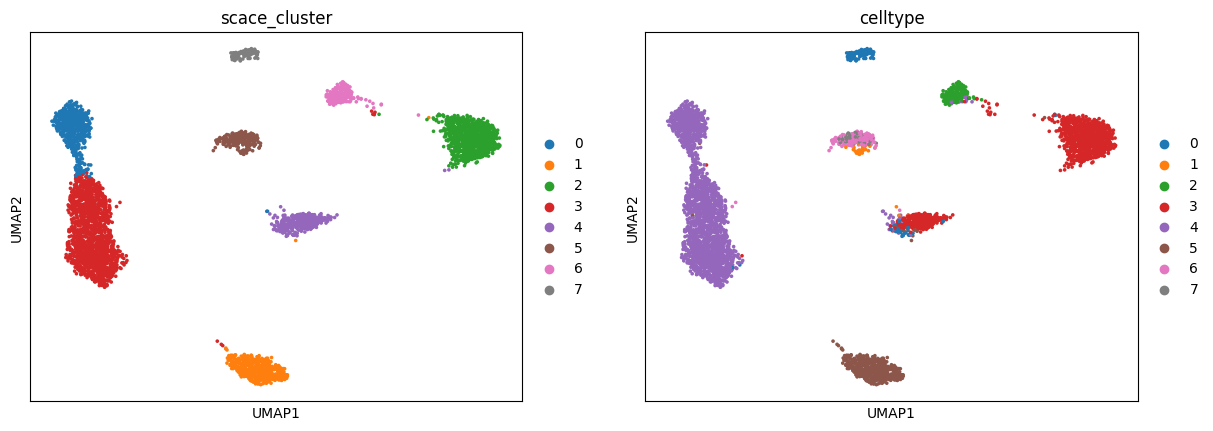

In [14]:
adata.obs['celltype'] = adata.obs['celltype'].astype(int).astype('category')
adata.obs['scace_cluster'] = adata.obs['scace_cluster'].astype(int).astype('category')
sc.pl.umap(adata, color=['scace_cluster', 'celltype'])



In [33]:
# emb_all[0] is the embedding after pre-training
# pred_all[0] is the initial clustering result after pre-training

adata_tmp = sc.AnnData(emb_all[0])
adata_tmp.obs['celltype'] = adata.obs['celltype']
adata_tmp.obs['scace_cluster'] = pred_all[0]
adata_tmp.obs['scace_cluster'] = adata_tmp.obs['scace_cluster'].astype(int).astype('category')

c:\users\rog\scace\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\users\rog\scace\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


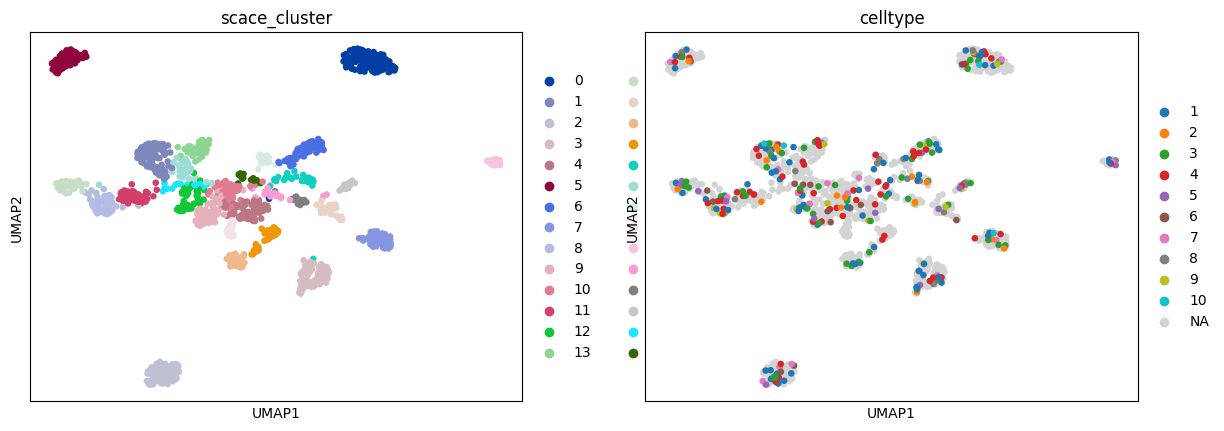

In [34]:
sc.pp.neighbors(adata_tmp)
sc.tl.umap(adata_tmp)
sc.pl.umap(adata_tmp, color=['scace_cluster', 'celltype'])

### Show clustering results before and after cluster merging

For the first time

In [15]:
# emb_all[1] is the embedding of the first cluster merging.
# pred_all[1] is the all clustering results from the first cluster merging, where
# pred_all[1][0] is the clustering result before cluster merging, and
# pred_all[1][0] is the clustering result after cluster merging.

adata_tmp = sc.AnnData(emb_all[1])
adata_tmp.obs['celltype'] = adata.obs['celltype']
adata_tmp.obs['scace_before'], adata_tmp.obs['scace_after'] = pred_all[1][0], pred_all[1][-1]
adata_tmp.obs['scace_before'] = adata_tmp.obs['scace_before'].astype(int).astype('category')
adata_tmp.obs['scace_after'] = adata_tmp.obs['scace_after'].astype(int).astype('category')

c:\users\rog\scace\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\users\rog\scace\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\users\rog\scace\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


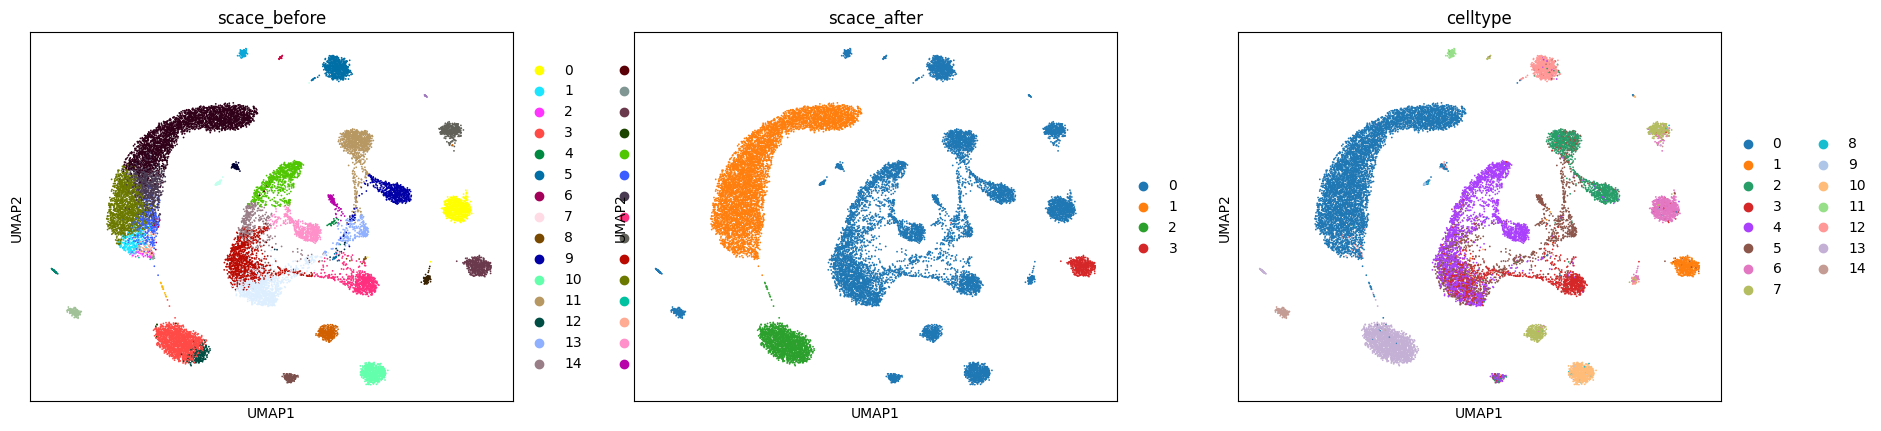

In [16]:
sc.pp.neighbors(adata_tmp)
sc.tl.umap(adata_tmp)
sc.pl.umap(adata_tmp, color=['scace_before', 'scace_after', 'celltype'])

For the final time

In [17]:
adata_tmp = sc.AnnData(emb_all[-2])
adata_tmp.obs['celltype'] = adata.obs['celltype']
adata_tmp.obs['scace_before'], adata_tmp.obs['scace_after'] = pred_all[2][0], pred_all[2][-1]
adata_tmp.obs['scace_before'] = adata_tmp.obs['scace_before'].astype(int).astype('category')
adata_tmp.obs['scace_after'] = adata_tmp.obs['scace_after'].astype(int).astype('category')

c:\users\rog\scace\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\users\rog\scace\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\users\rog\scace\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


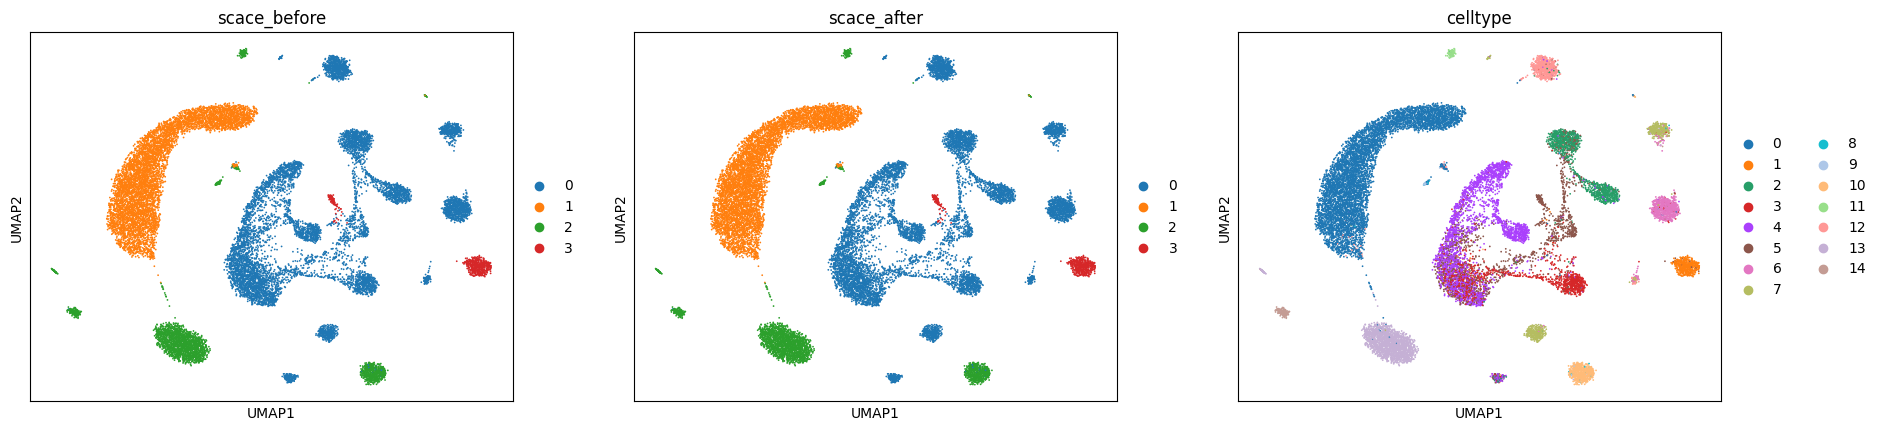

In [18]:
sc.pp.neighbors(adata_tmp)
sc.tl.umap(adata_tmp)
sc.pl.umap(adata_tmp, color=['scace_before', 'scace_after', 'celltype'])